# EDA

In [92]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('ggplot')

import missingno as msno
import random

from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer



### Load datasets

In [49]:
directory = "/Users/rnirms/Documents/omdena/data/CPCB_downloads/2023-03-07/csv_latest/"
all_files = os.listdir(directory)
csv_files = [file for file in all_files if file.endswith(".csv")]
csv_files = sorted(csv_files)
print(csv_files)

['BandraKurlaComplexMumbaiIITM.csv', 'BandraMumbaiMPCB.csv', 'BorivaliEastMumbaiIITM.csv', 'BorivaliEastMumbaiMPCB.csv', 'ChakalaAndheriEastMumbaiIITM.csv', 'ChhatrapatiShivajiIntlAirportT2MumbaiMPCB.csv', 'ColabaMumbaiMPCB.csv', 'DeonarMumbaiIITM.csv', 'KandivaliEastMumbaiMPCB.csv', 'KhindipadaBhandupWestMumbaiIITM.csv', 'KurlaMumbaiMPCB.csv', 'MaladWestMumbaiIITM.csv', 'MazgaonMumbaiIITM.csv', 'MulundWestMumbaiMPCB.csv', 'NavyNagarColabaMumbaiIITM.csv', 'PowaiMumbaiMPCB.csv', 'SiddharthNagarWorliMumbaiIITM.csv', 'SionMumbaiMPCB.csv', 'VasaiWestMumbaiMPCB.csv', 'VileParleWestMumbaiMPCB.csv', 'WorliMumbaiMPCB.csv']


In [50]:
df_list = []
station_names = []
for filename in csv_files: 
    df_temp = pd.read_csv(os.path.join(directory, filename))
    df_list.append(df_temp)
    name, _ = os.path.splitext(filename)
    station_names.append(name)
data_dict = dict(zip(station_names, df_list))

### Clean data

In [51]:
def clean_data(data):
    data = data.iloc[:, 2:-1] # Remove columns: Unnamed:0, From Date, Unnamed:23
    data = data.rename(columns={'To Date': 'Date'}) # Rename date column
    data["Date"] = pd.to_datetime(data.Date, format='%d-%m-%Y %H:%M') # Format Date column as datetime
    data = data.replace('None', np.NaN) # Replace all 'None' to NaN
    data[data.columns[1:]] = data[data.columns[1:]].astype(float) # Format all other columns to float 

    return data 


In [52]:
for key in data_dict.keys():
    data_dict[key] = clean_data(data_dict[key])

In [53]:
data_dict['KurlaMumbaiMPCB'].columns

Index(['Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO',
       'Ozone', 'Benzene', 'Toluene', 'Eth-Benzene', 'MP-Xylene', 'RH', 'WS',
       'WD', 'SR', 'BP', 'AT', 'TOT-RF'],
      dtype='object')

### Check missing values

In [54]:
df = data_dict['KurlaMumbaiMPCB']

In [55]:
begin_date = list(df['Date'])[0]
end_date = list(df['Date'])[-1]
print(f'Data date range: {begin_date} to {end_date}')

Data date range: 2021-01-01 00:15:00 to 2023-03-07 00:00:00


Sanity check: What should be the total number of rows in this dataset?

In [56]:
n_per_hour = 4
n_per_day = n_per_hour * 24
days = (365 + 366 + (30+28+6)) 
total_rows = days * n_per_day + 1 # 1 extra entry for 2023-03-07 00:00:00
total_rows

76321

In [57]:
len(df)

76321

#### All stations 

In [58]:
mv_data = pd.DataFrame()
for key in data_dict.keys():
    data = data_dict[key]
    missing_values = data.isnull().sum()/len(data)
    missing_values = missing_values.to_frame().reset_index().T
    missing_values.columns = missing_values.iloc[0] #use top row as column header
    missing_values = missing_values[1:] #remove top row

    mv_data = pd.concat([mv_data, missing_values], ignore_index=True) # Add to the missing values table 

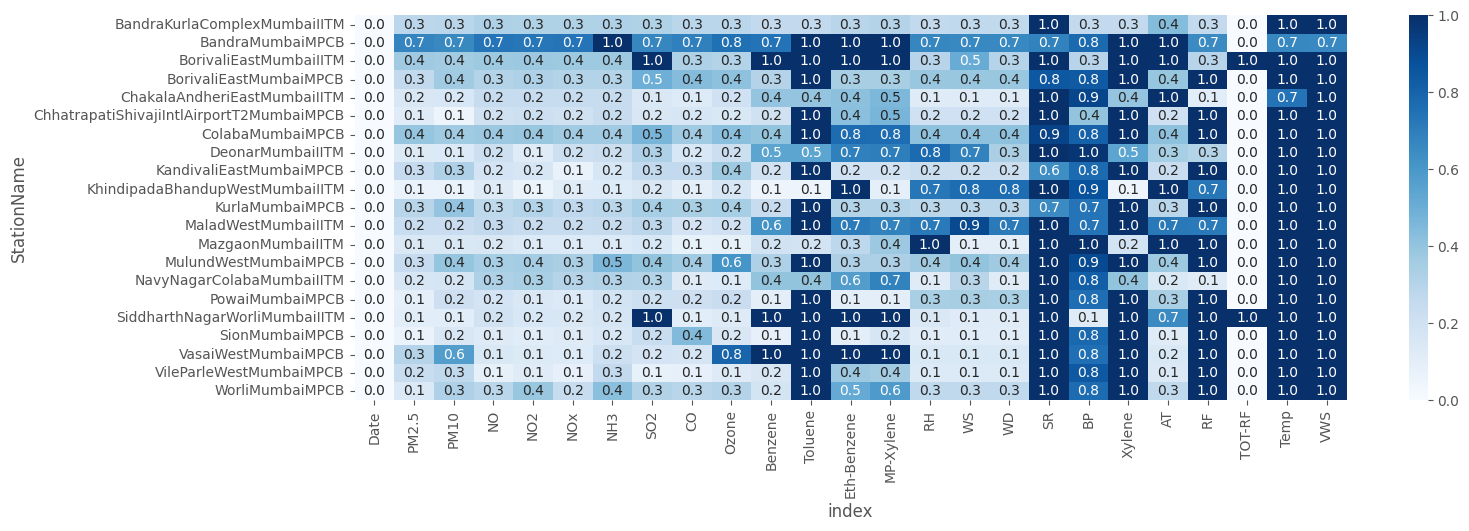

In [59]:
mv_data = mv_data.replace(np.NaN, 1)
mv_data['StationName'] = station_names
mv_data = mv_data.set_index('StationName')

plt.figure(figsize=(16,5))
sns.heatmap(mv_data, annot=True, cmap='Blues', fmt='.1f') # Create the heatmap
plt.show() # Show the plot

#### Each station missing-ness 

<AxesSubplot: >

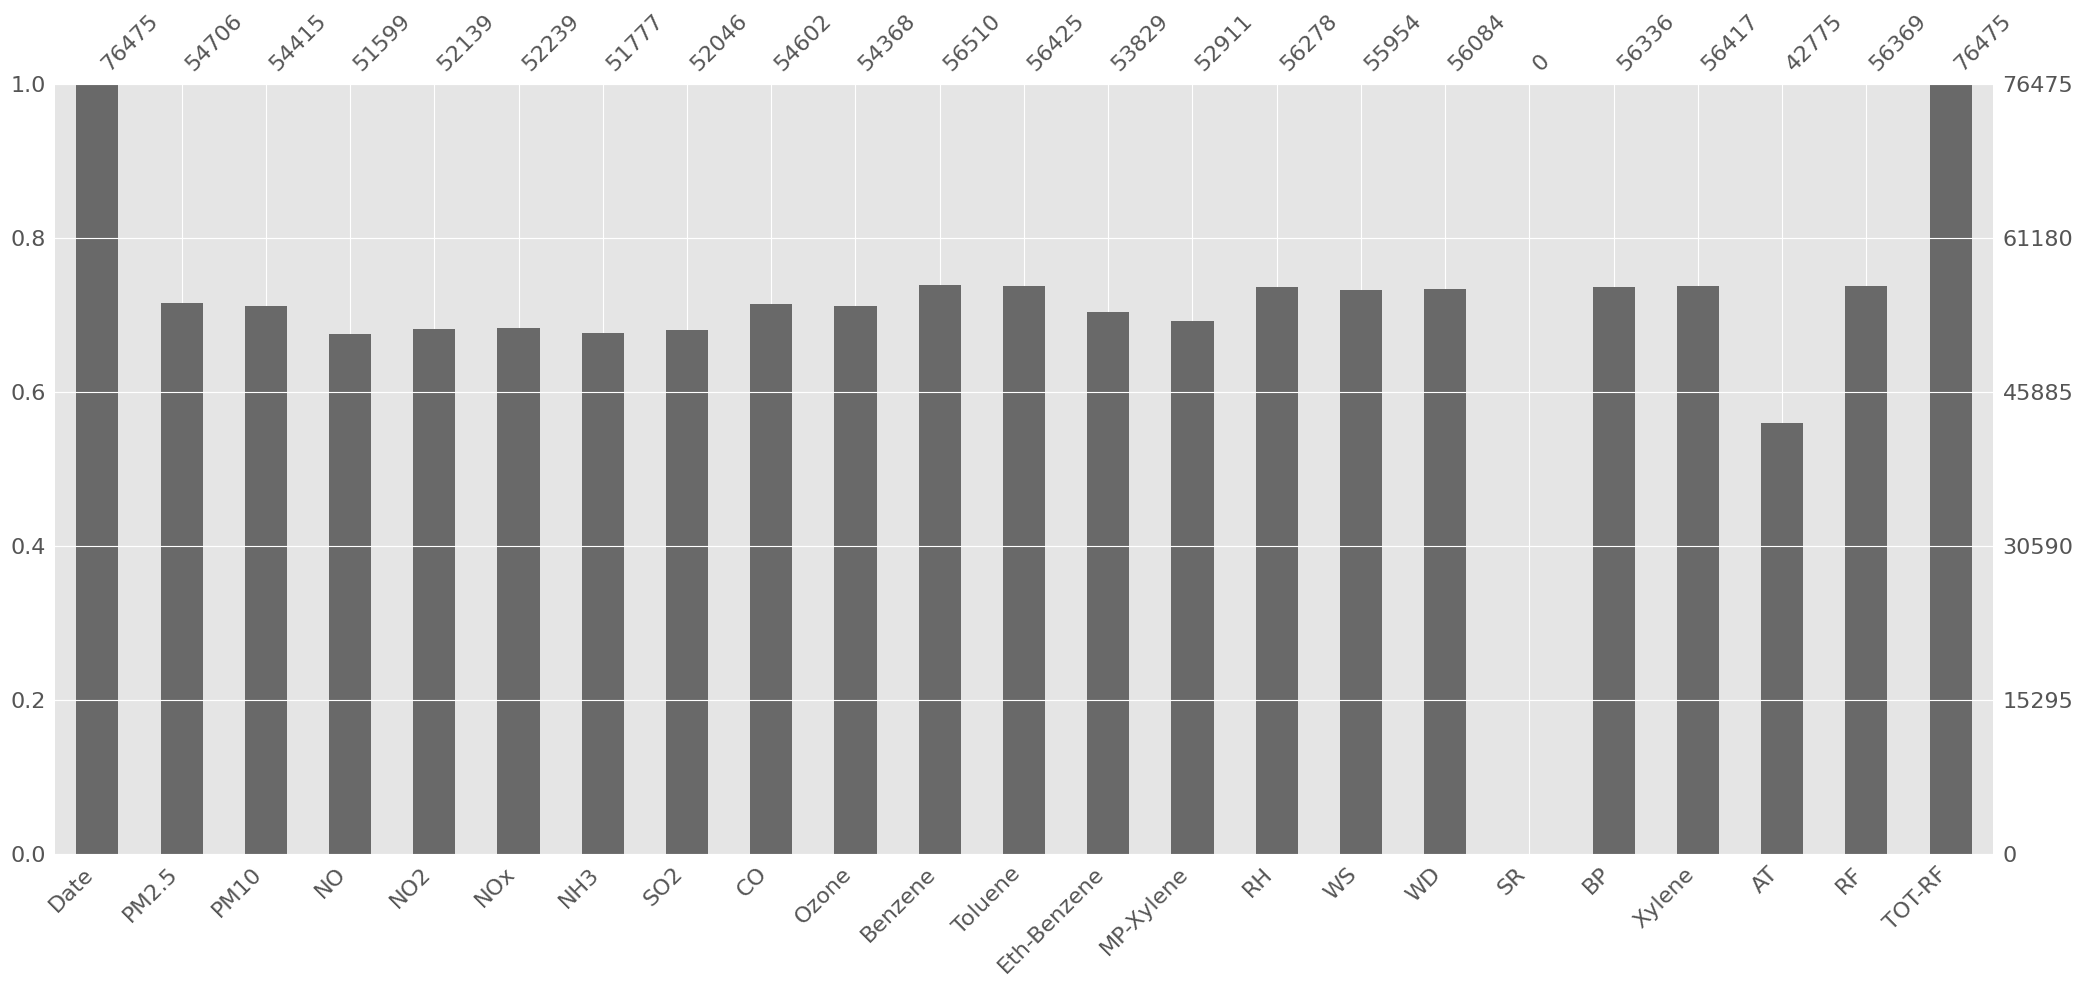

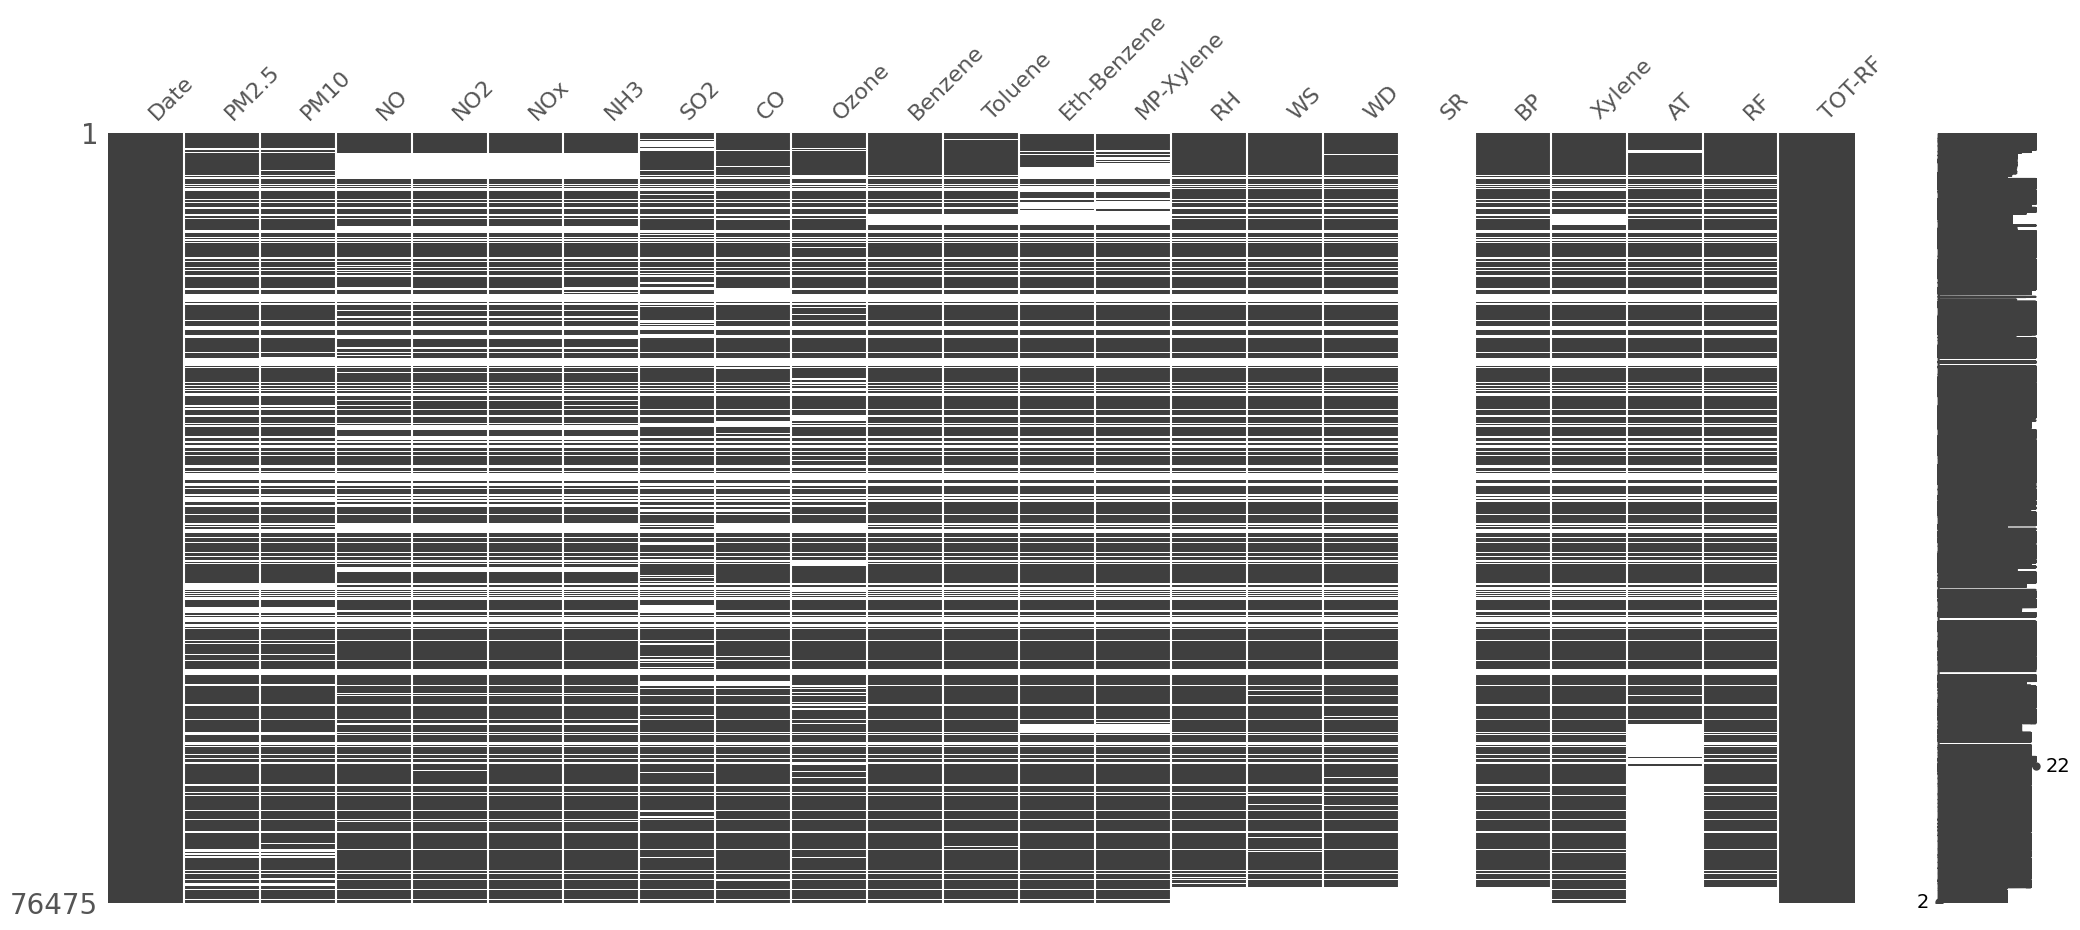

In [62]:
plt.rcParams['figure.figsize']=(20,6)
msno.bar(data_dict['BandraKurlaComplexMumbaiIITM'])
msno.matrix(data_dict['BandraKurlaComplexMumbaiIITM'])

BandraKurlaComplexMumbaiIITM: 
* Pollution parameters - all available for around 70%
* Weather parameters: 
    * SR column missing 
    * RH, WS, WD, BP missing recently
    * AT missing recently for a while

<AxesSubplot: >

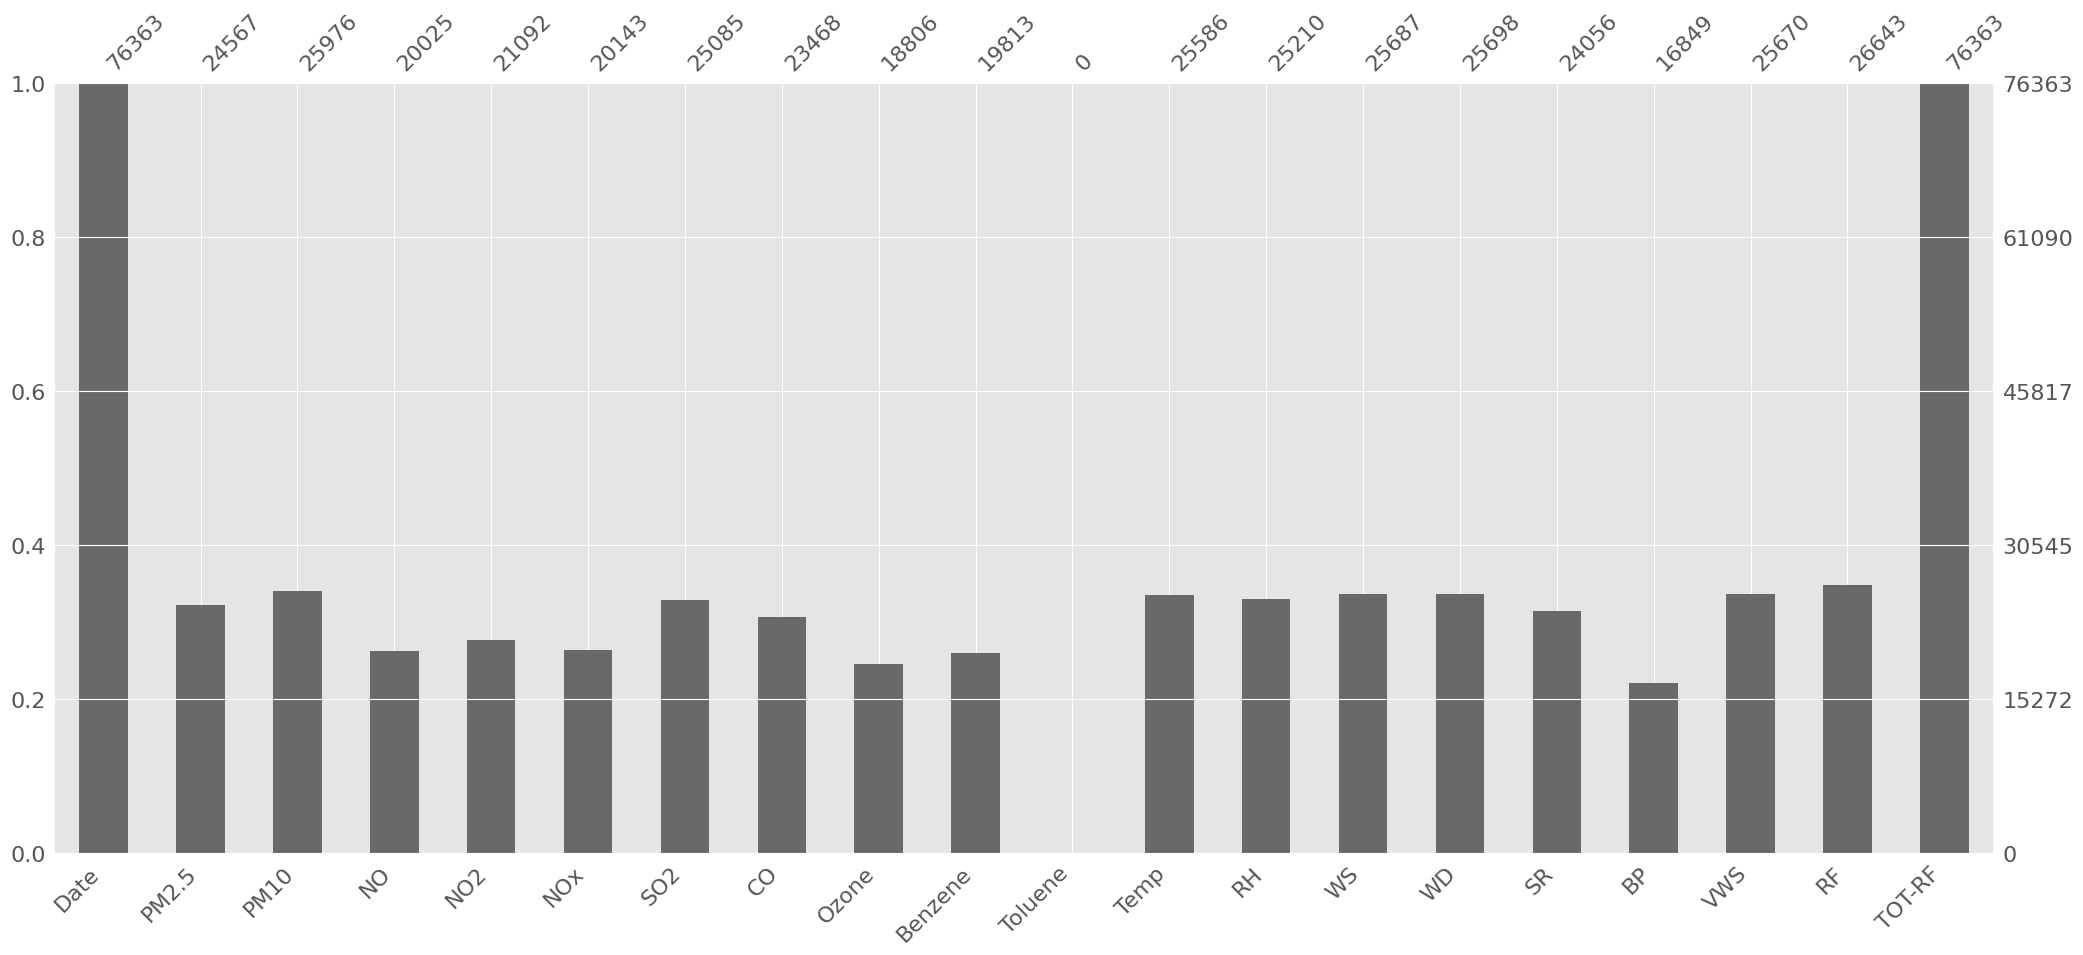

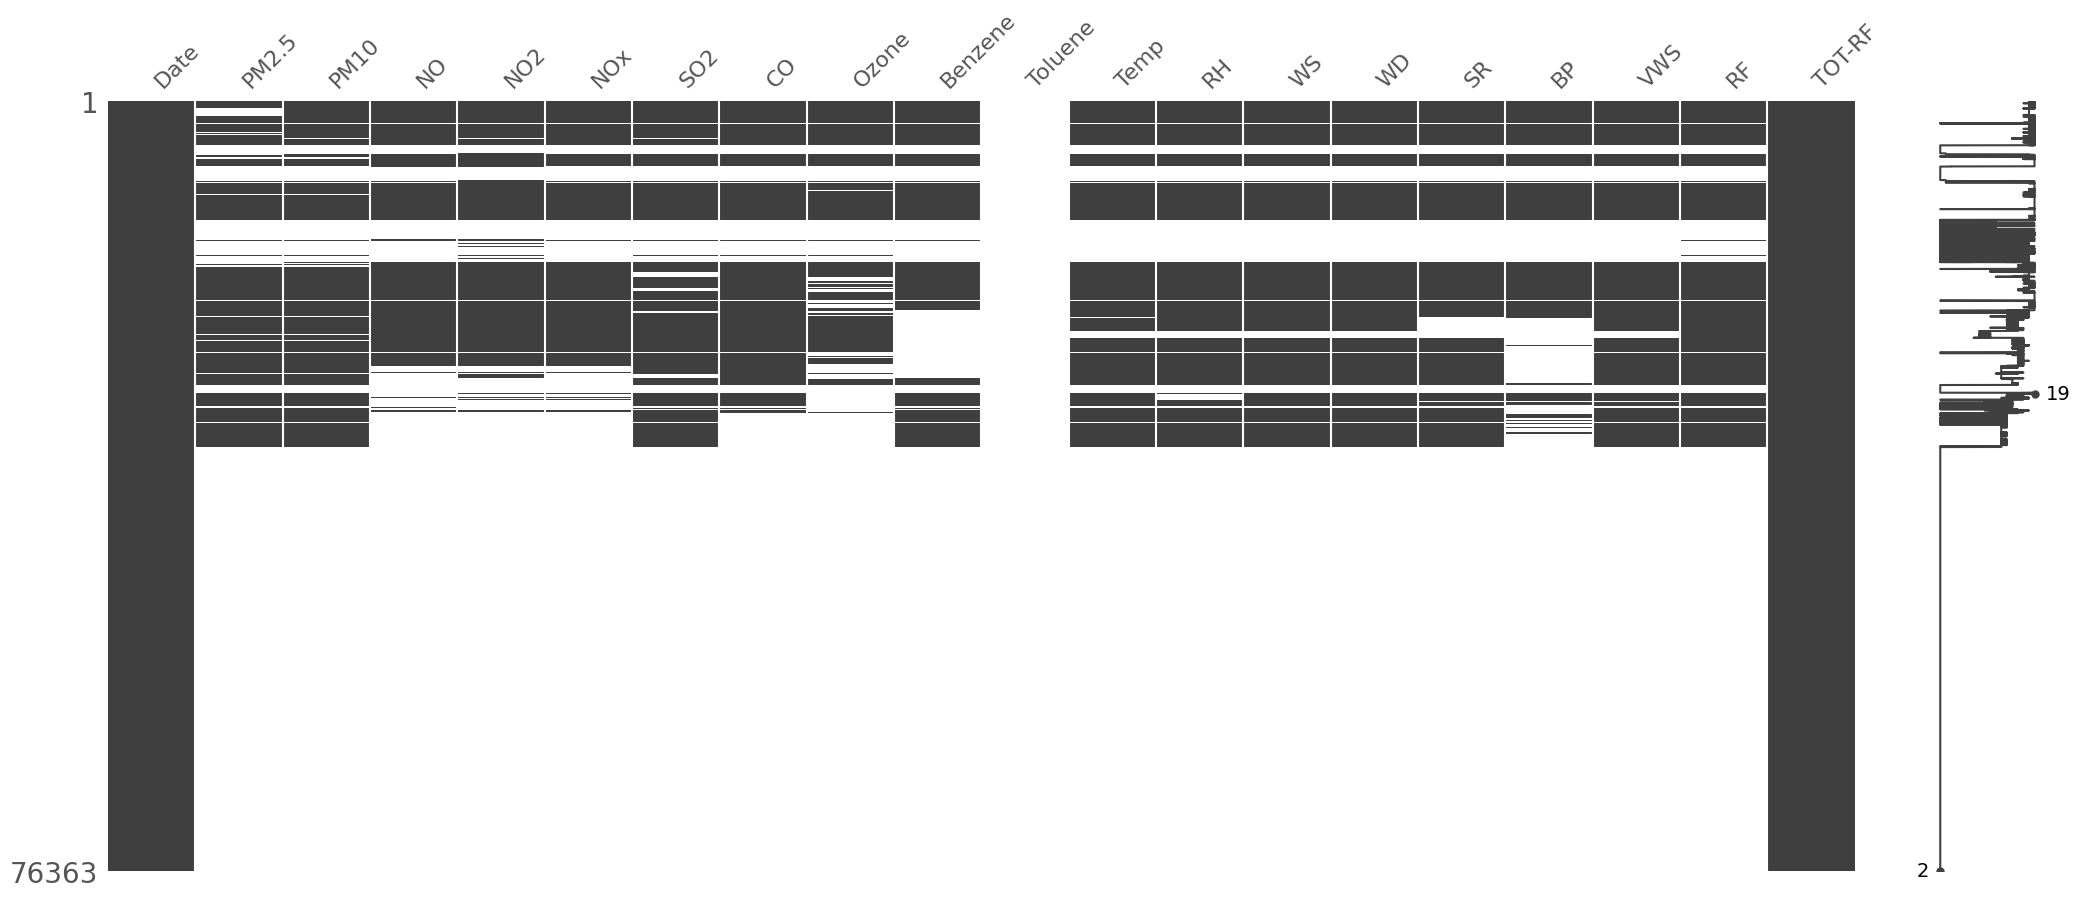

In [63]:
plt.rcParams['figure.figsize']=(20,6)
msno.bar(data_dict['BandraMumbaiMPCB'])
msno.matrix(data_dict['BandraMumbaiMPCB'])

BandraMumbaiMPCB: 
* All sensors down recently

<AxesSubplot: >

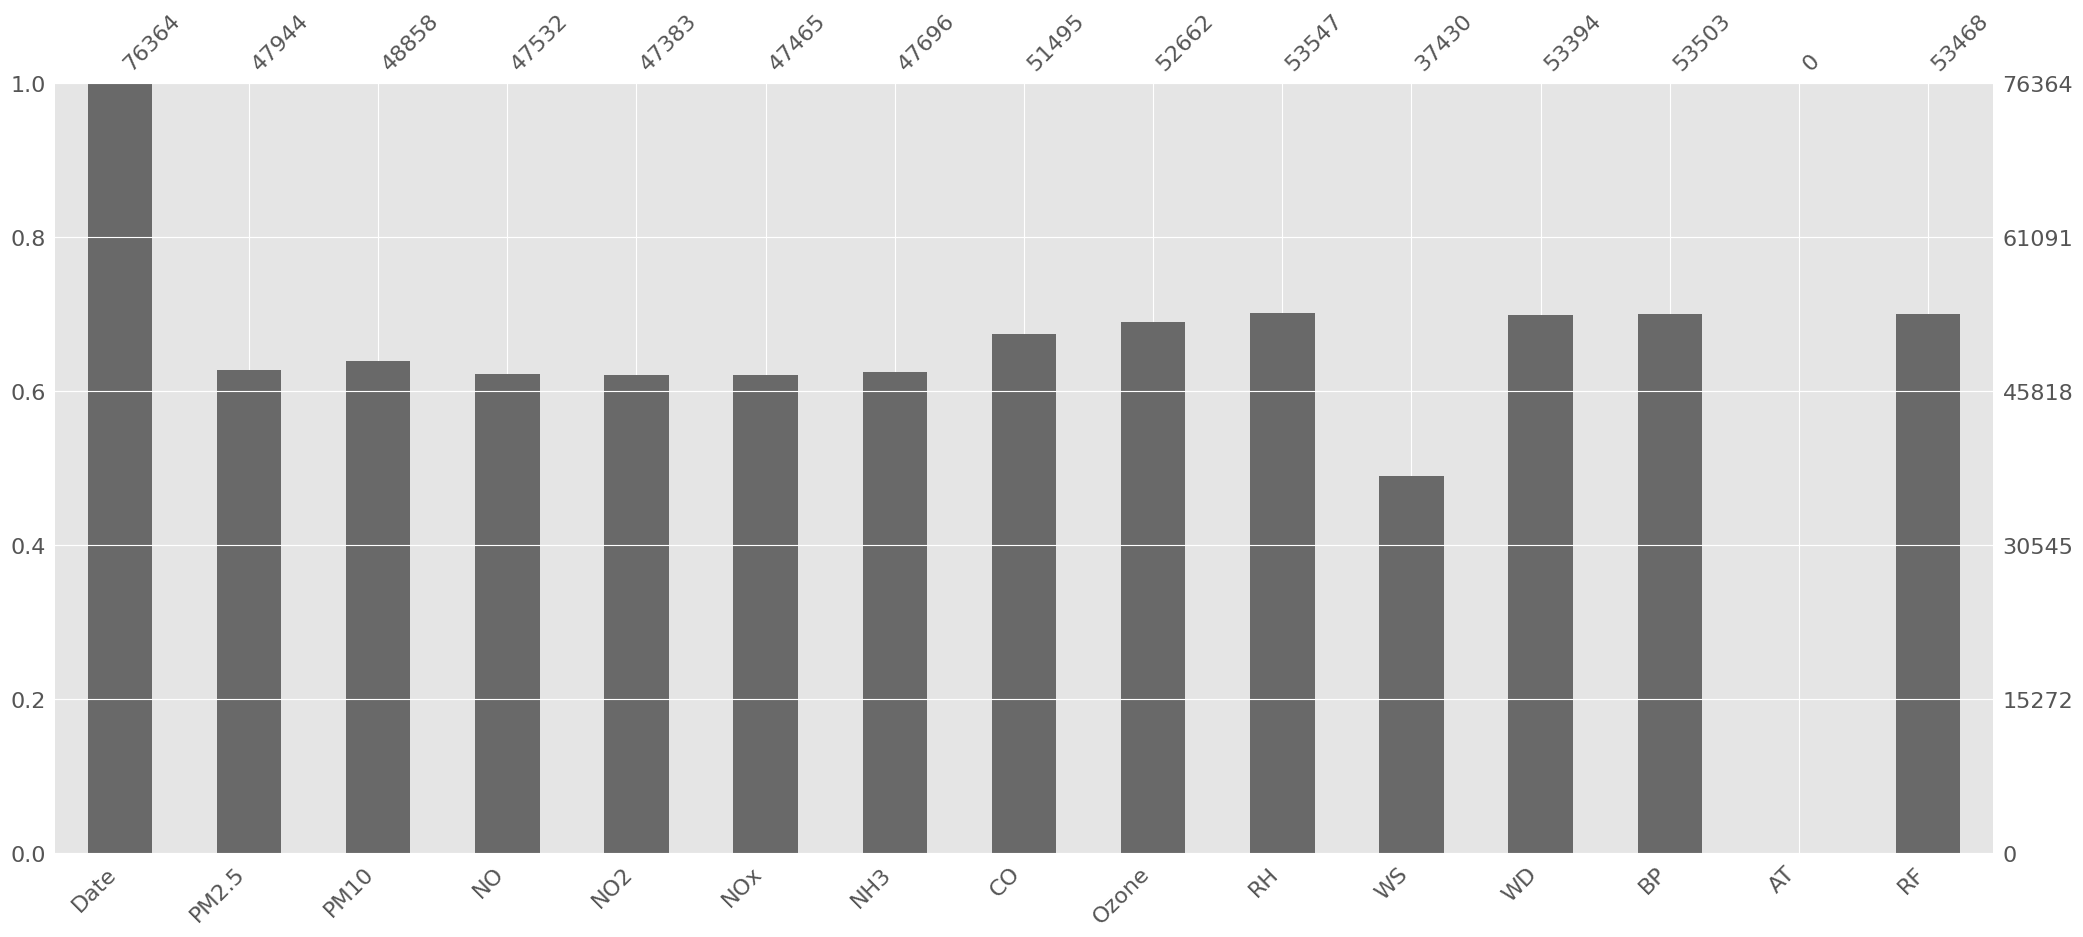

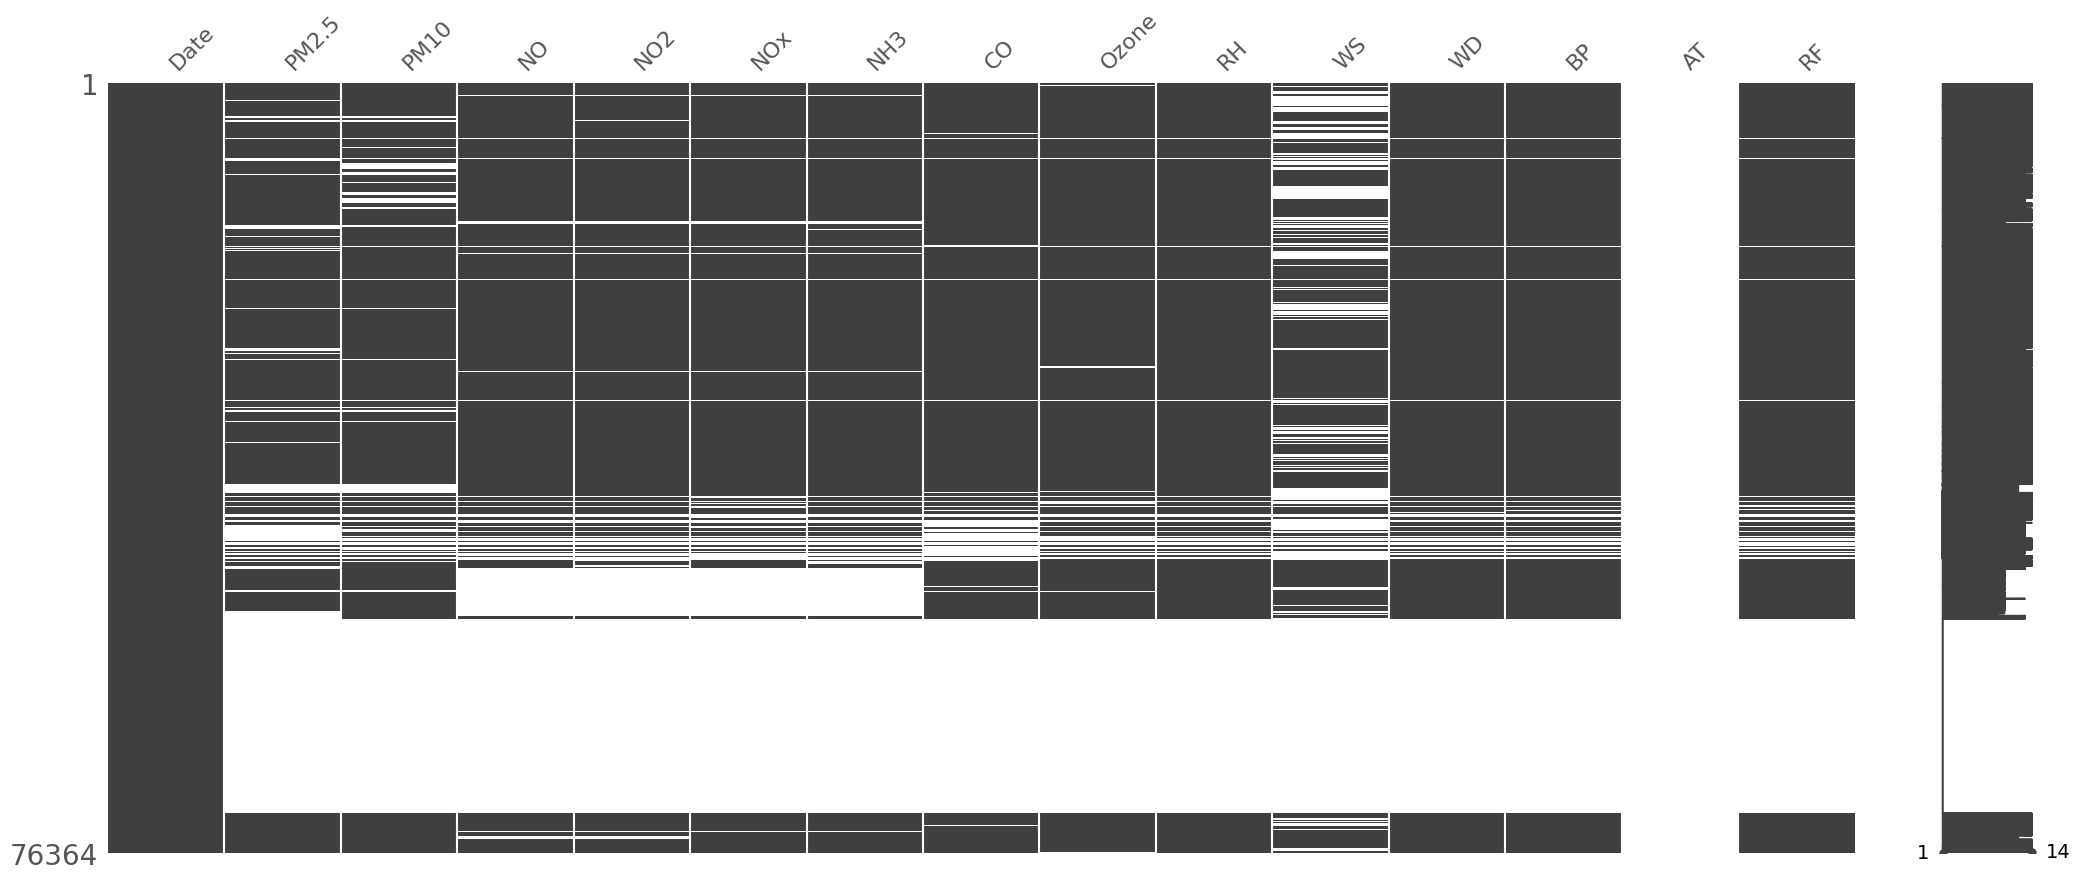

In [64]:
plt.rcParams['figure.figsize']=(20,6)
msno.bar(data_dict['BorivaliEastMumbaiIITM'])
msno.matrix(data_dict['BorivaliEastMumbaiIITM'])

BorivaliEastMumbaiIITM: 
* All sensors down for a good chunk of time, recovered recently

<AxesSubplot: >

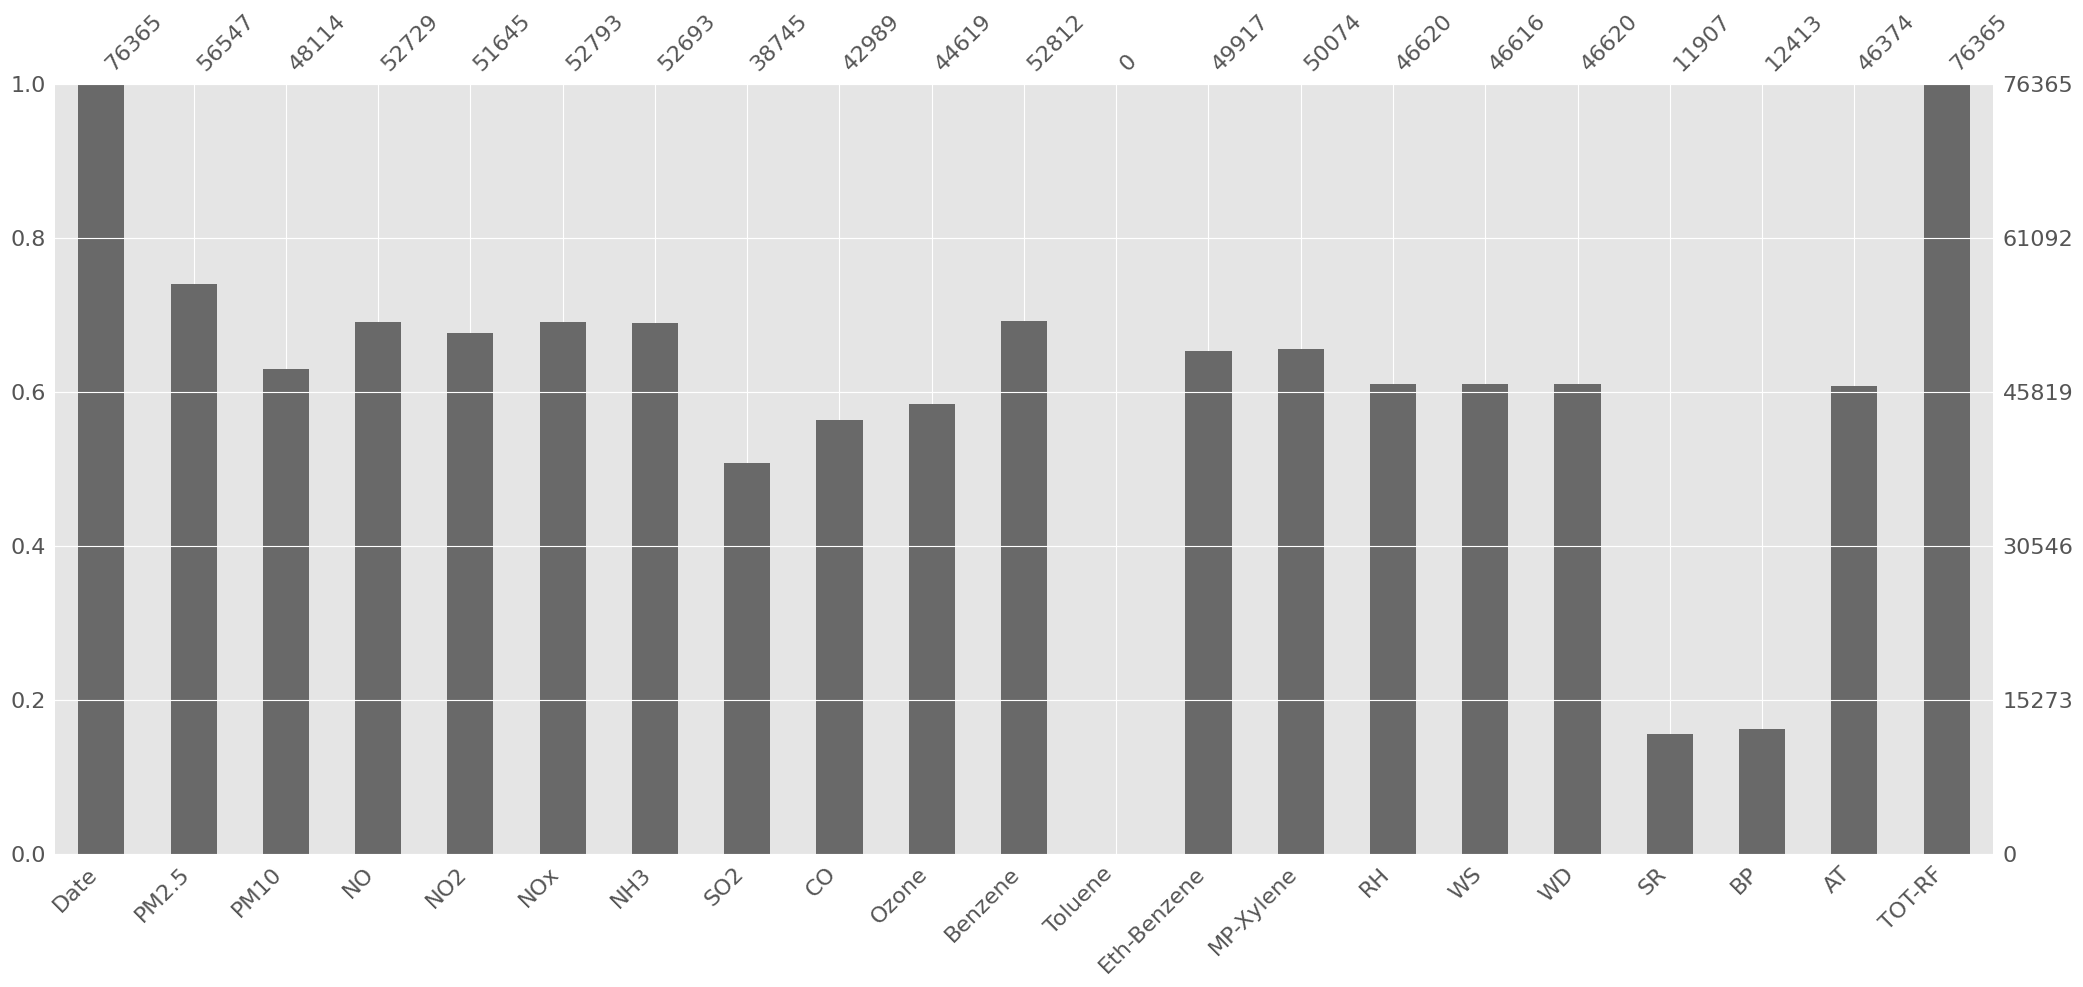

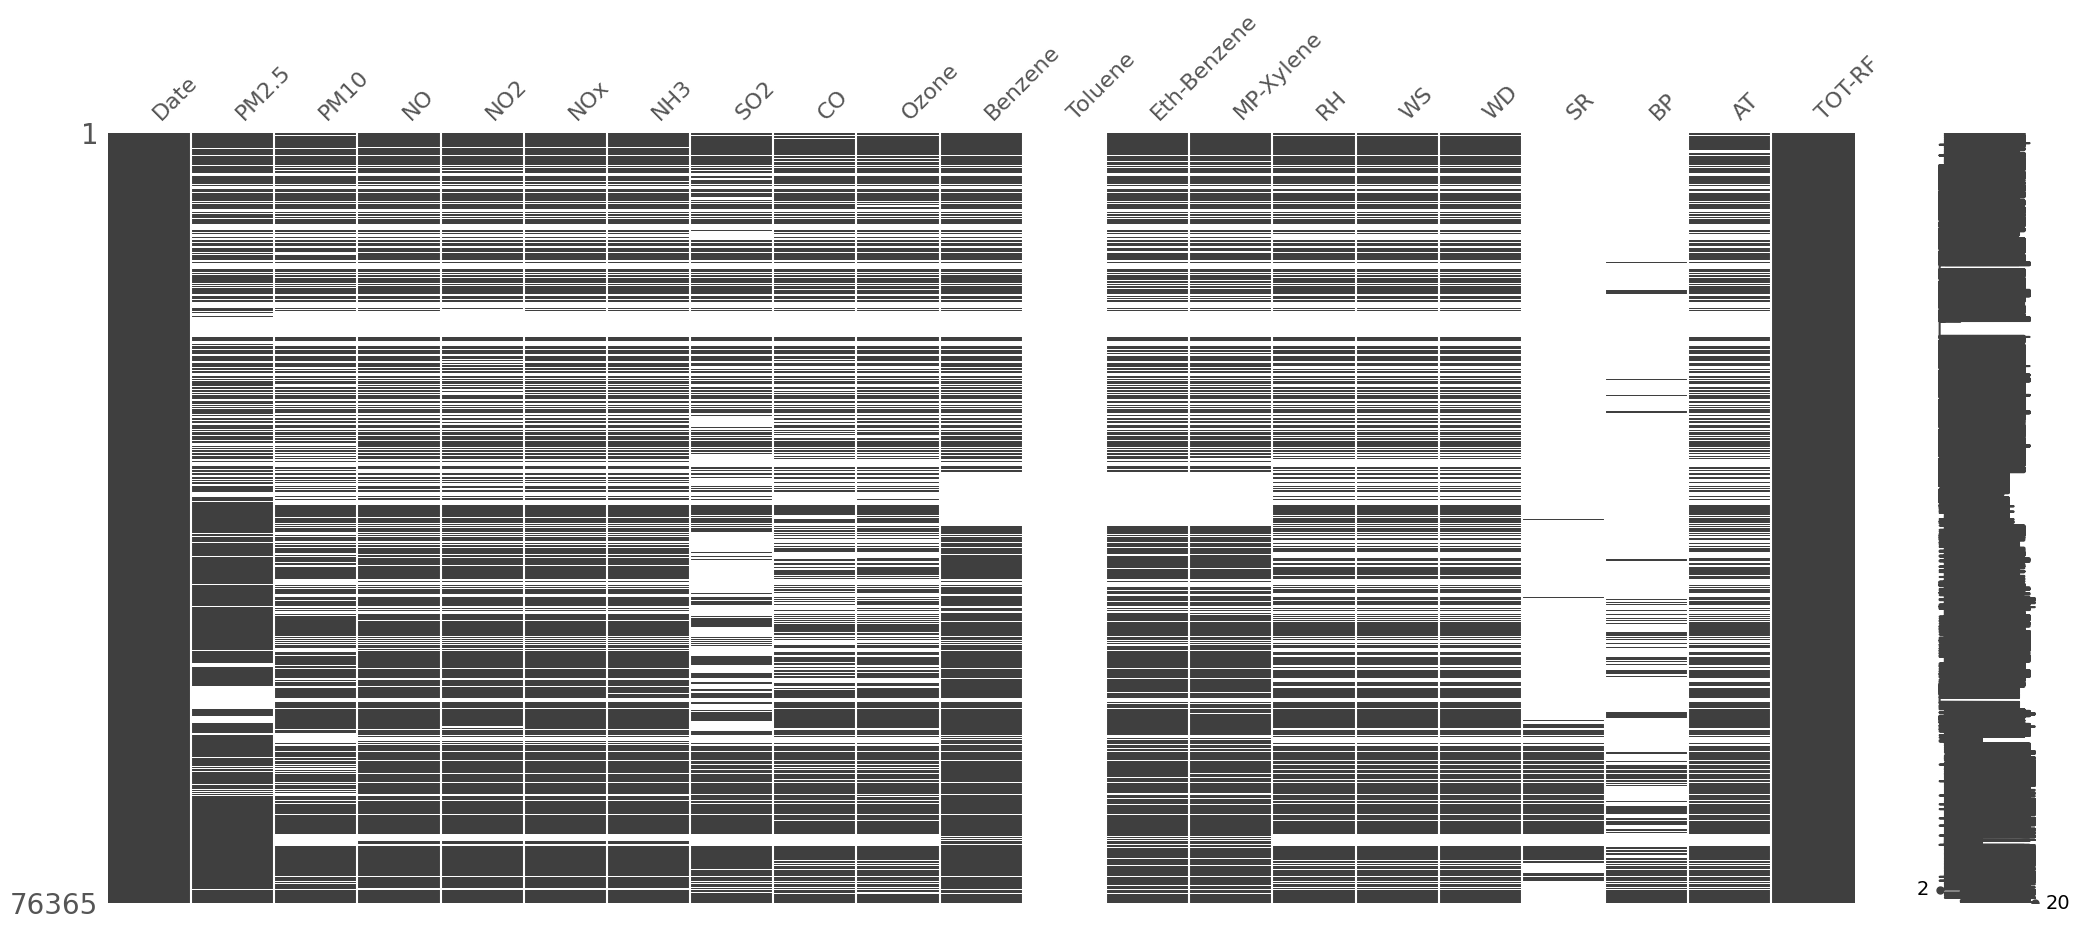

In [65]:
plt.rcParams['figure.figsize']=(20,6)
msno.bar(data_dict['BorivaliEastMumbaiMPCB'])
msno.matrix(data_dict['BorivaliEastMumbaiMPCB'])

BorivaliEastMumbaiMPCB: 
* All sensors for a chunk of period
* Pollutants
    * Toluene completely missing 
    * Benzene, Eth-Benzene, MP-Xylene have blocks of rows missing
* Weather 
    * SR and BP limited data 

/Users/rnirms/anaconda3/envs/mlops-course/lib/python3.8/site-packages/missingno/missingno.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


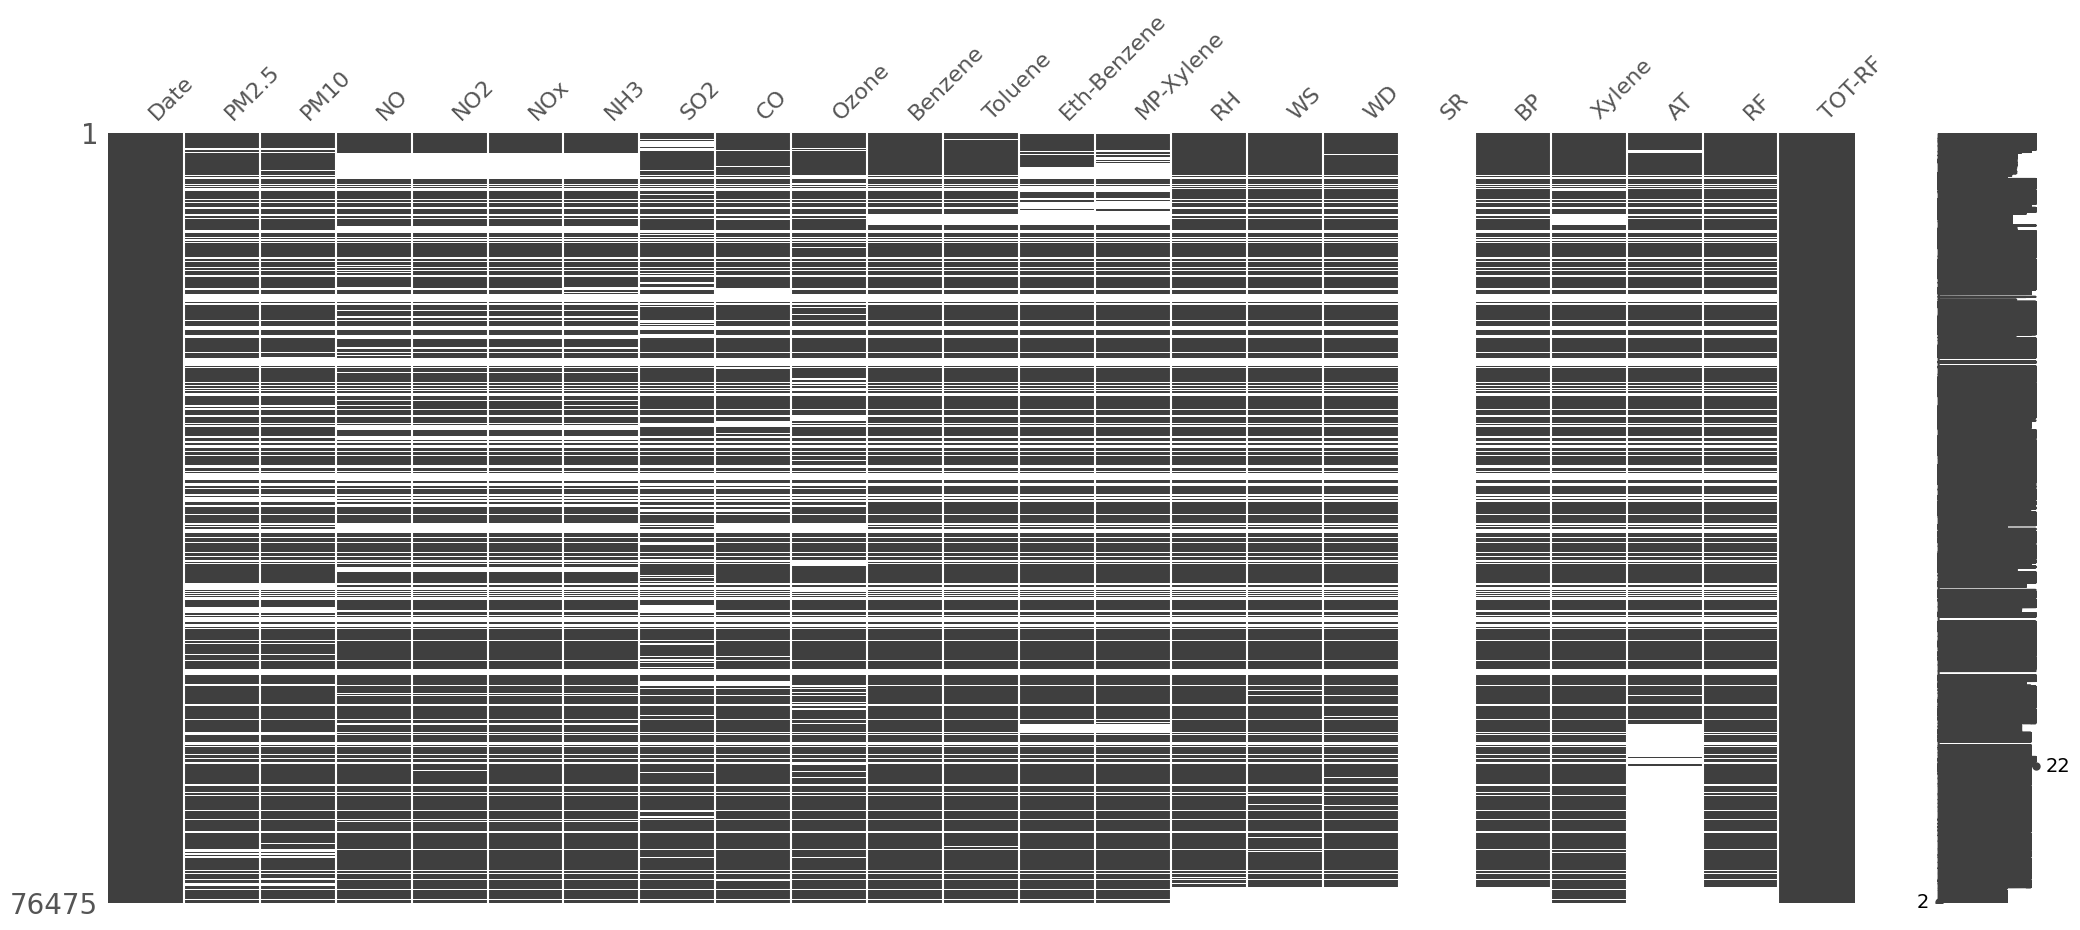

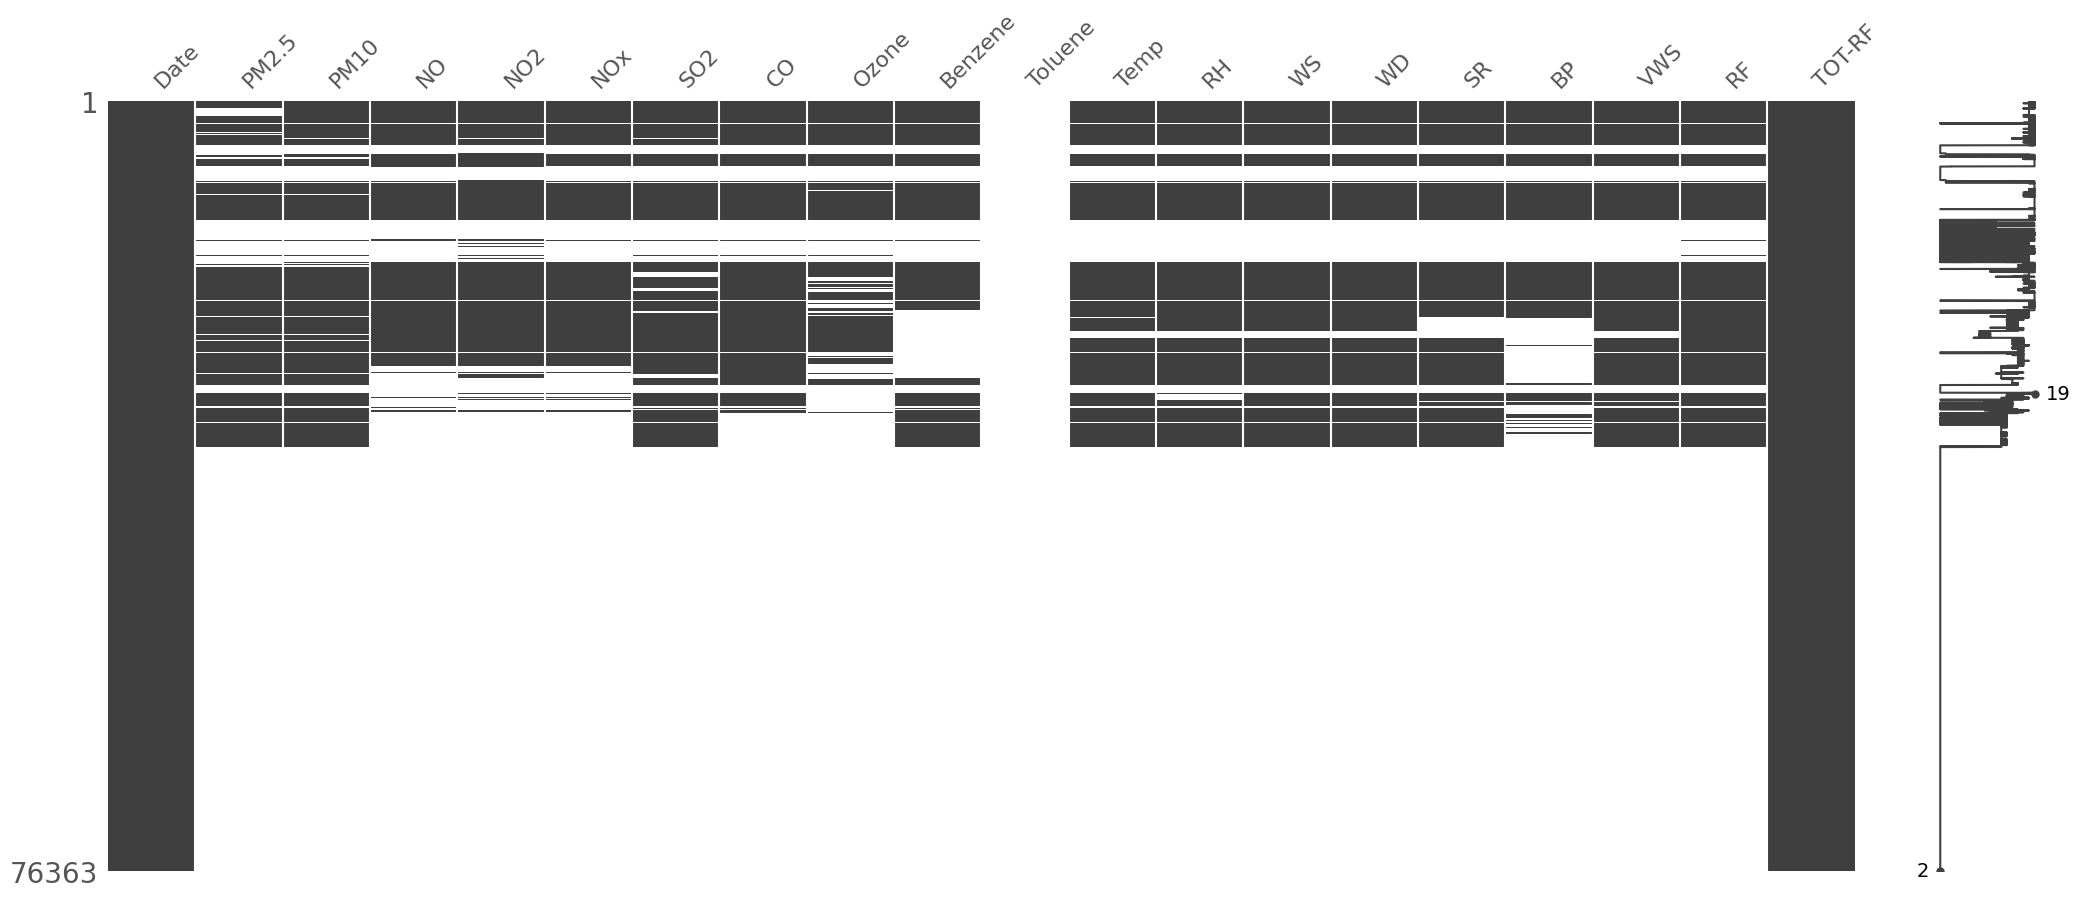

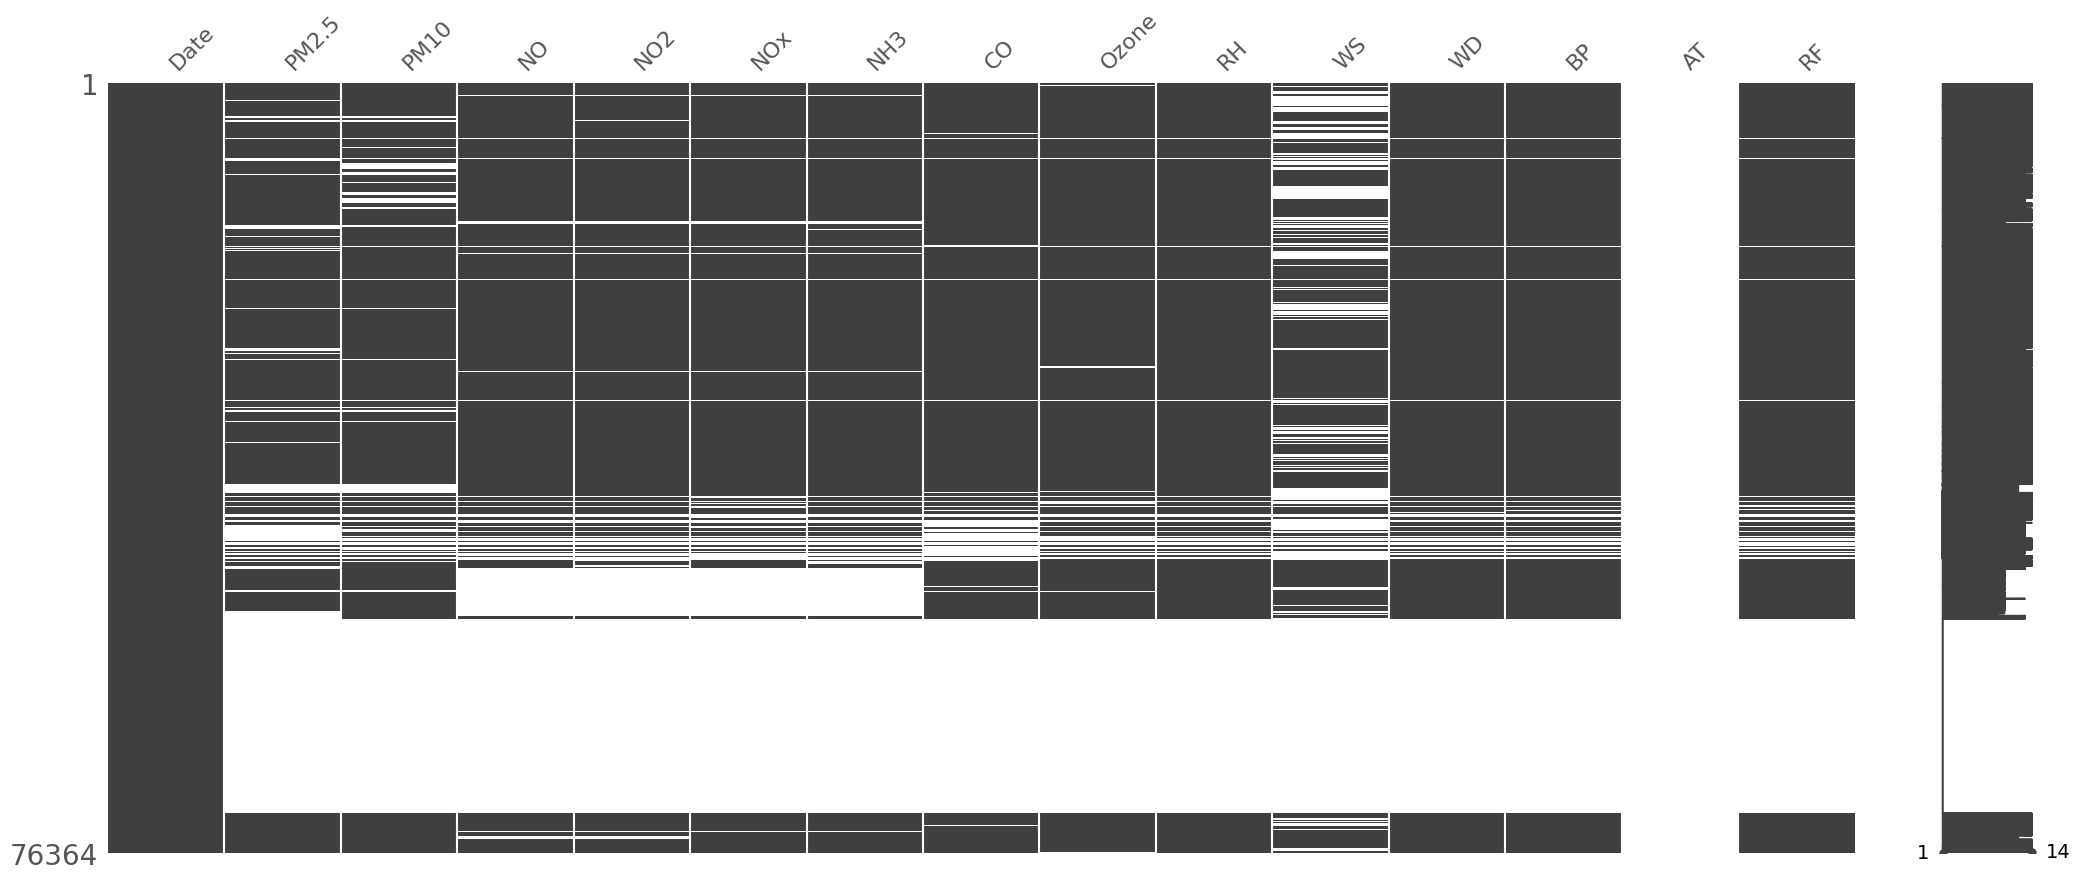

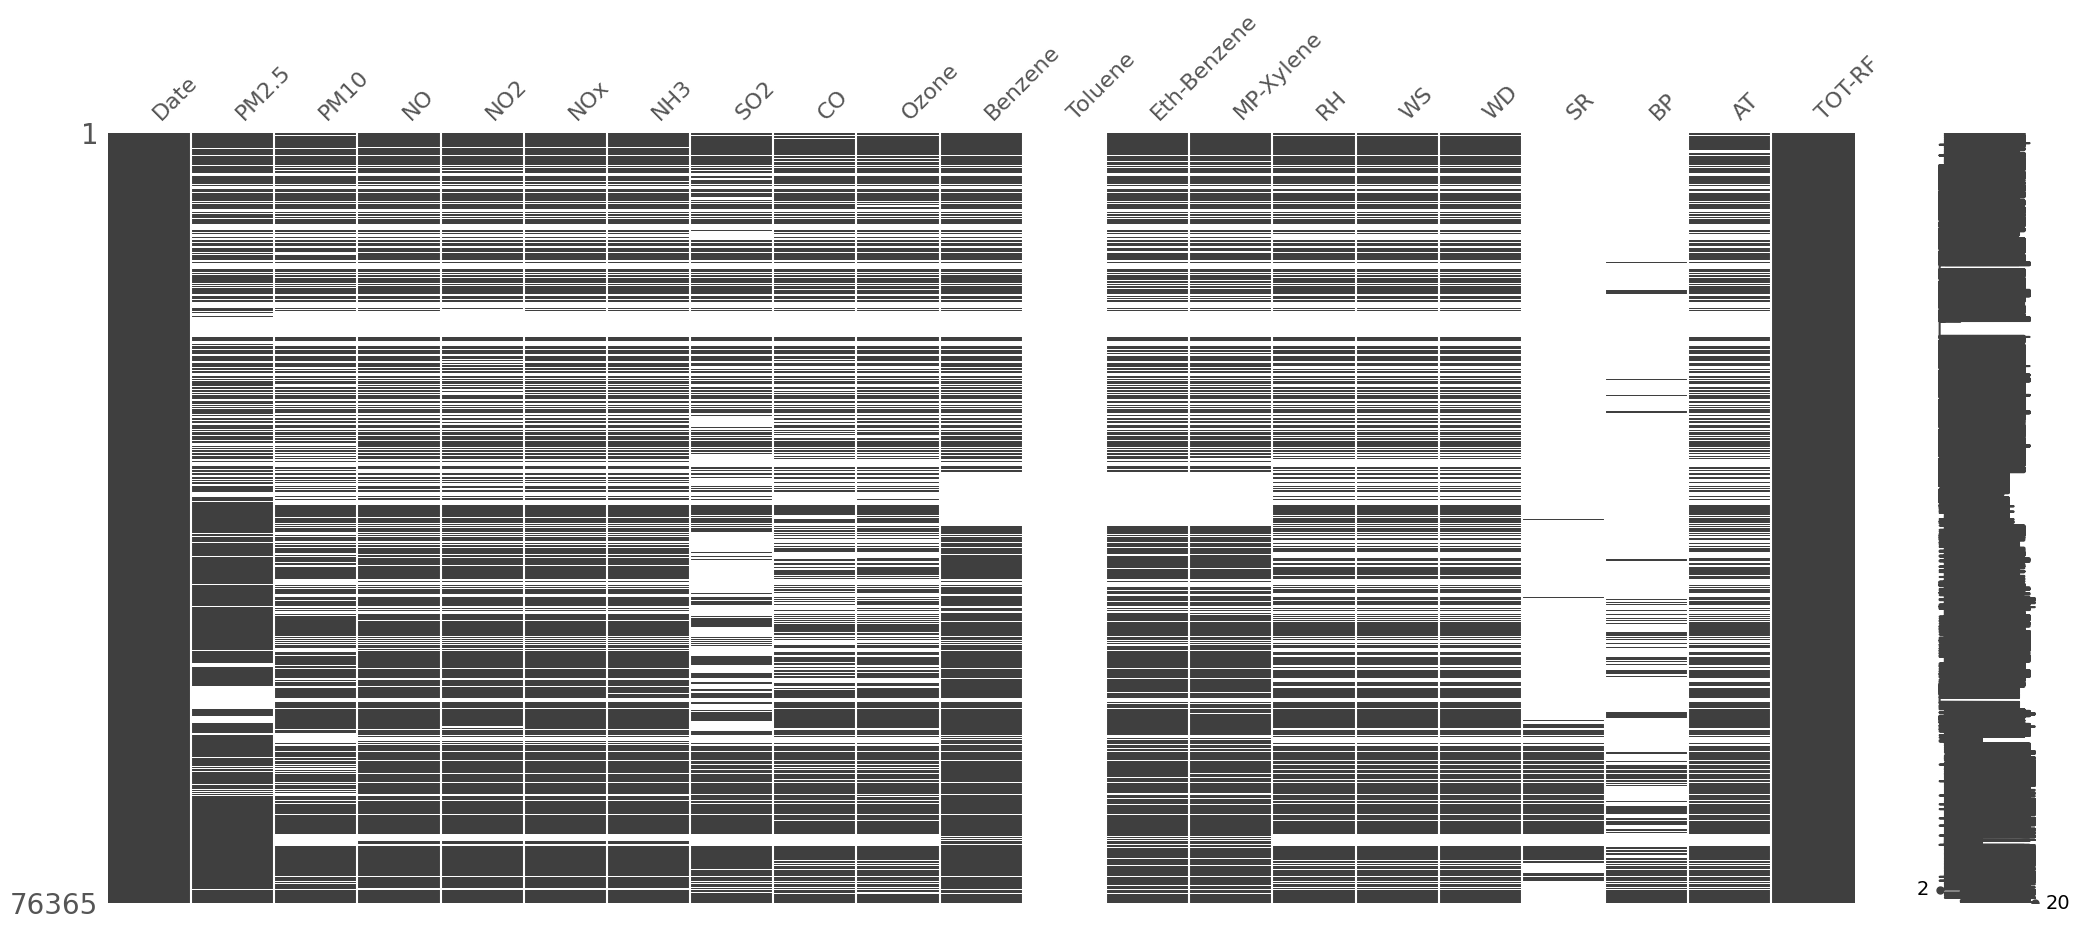

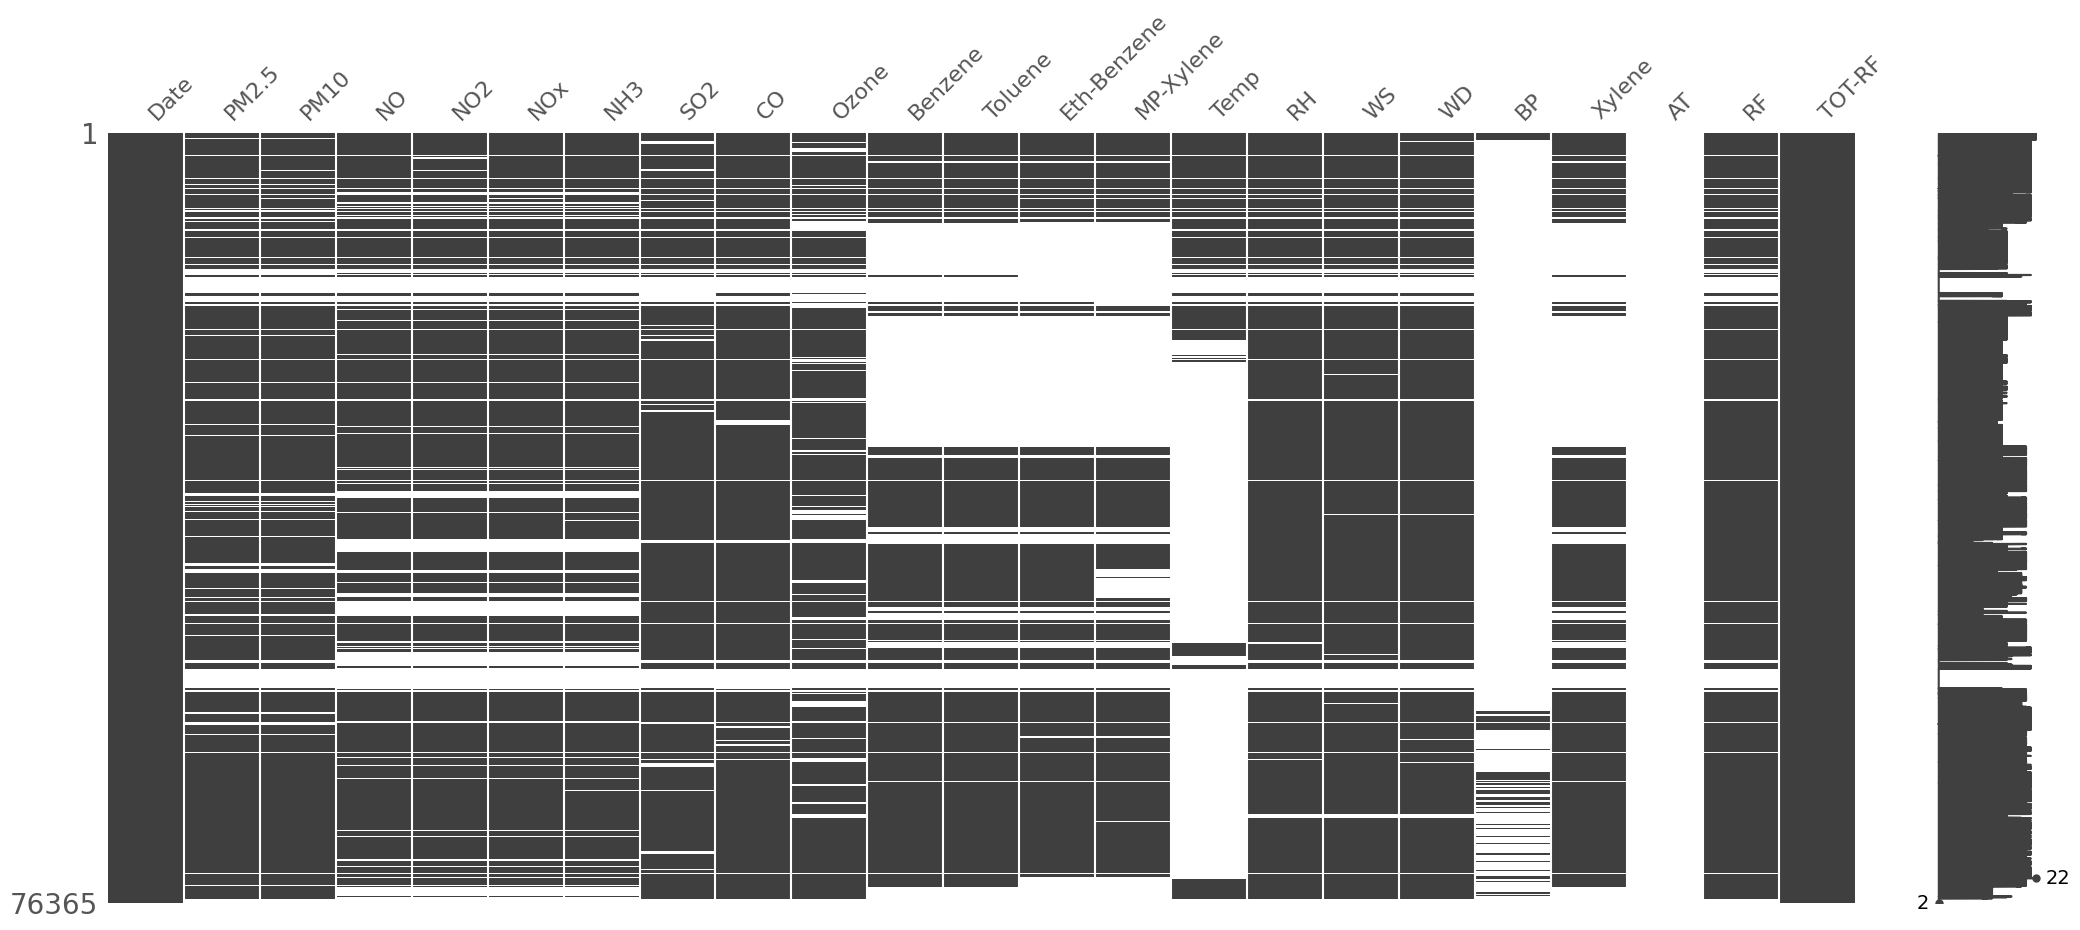

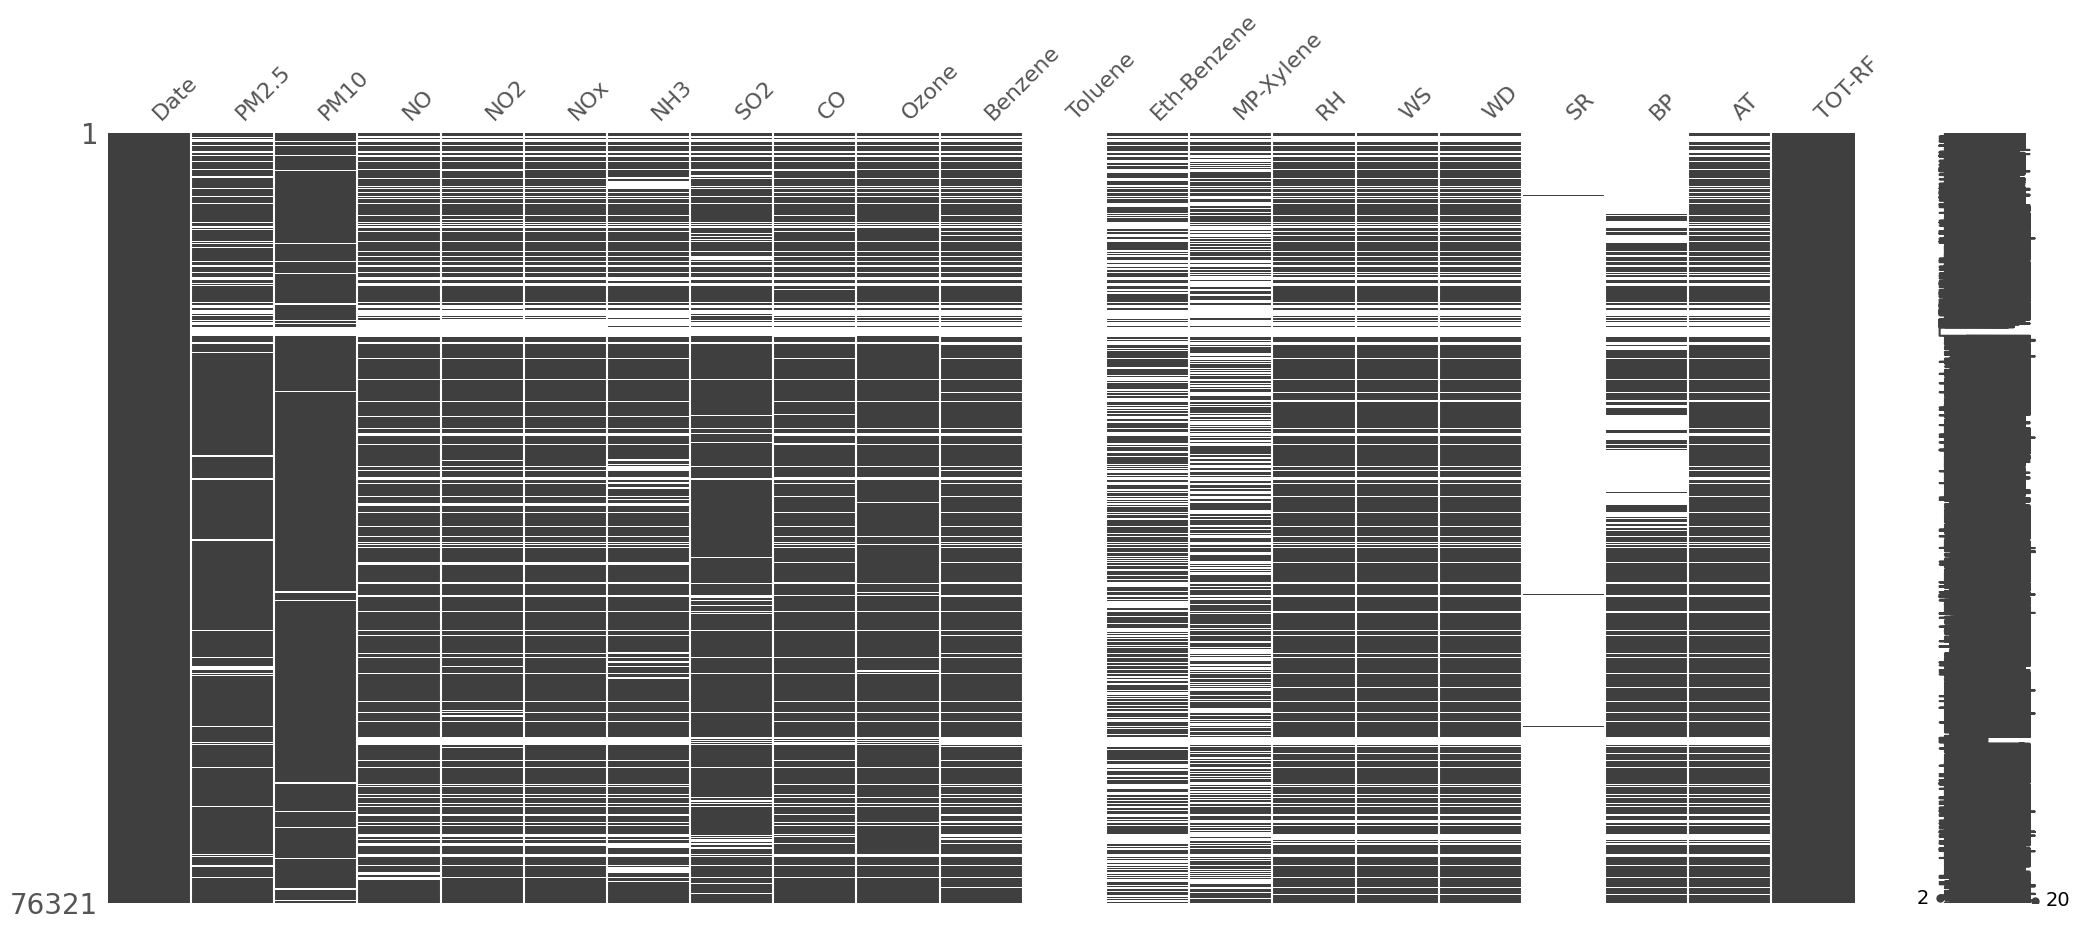

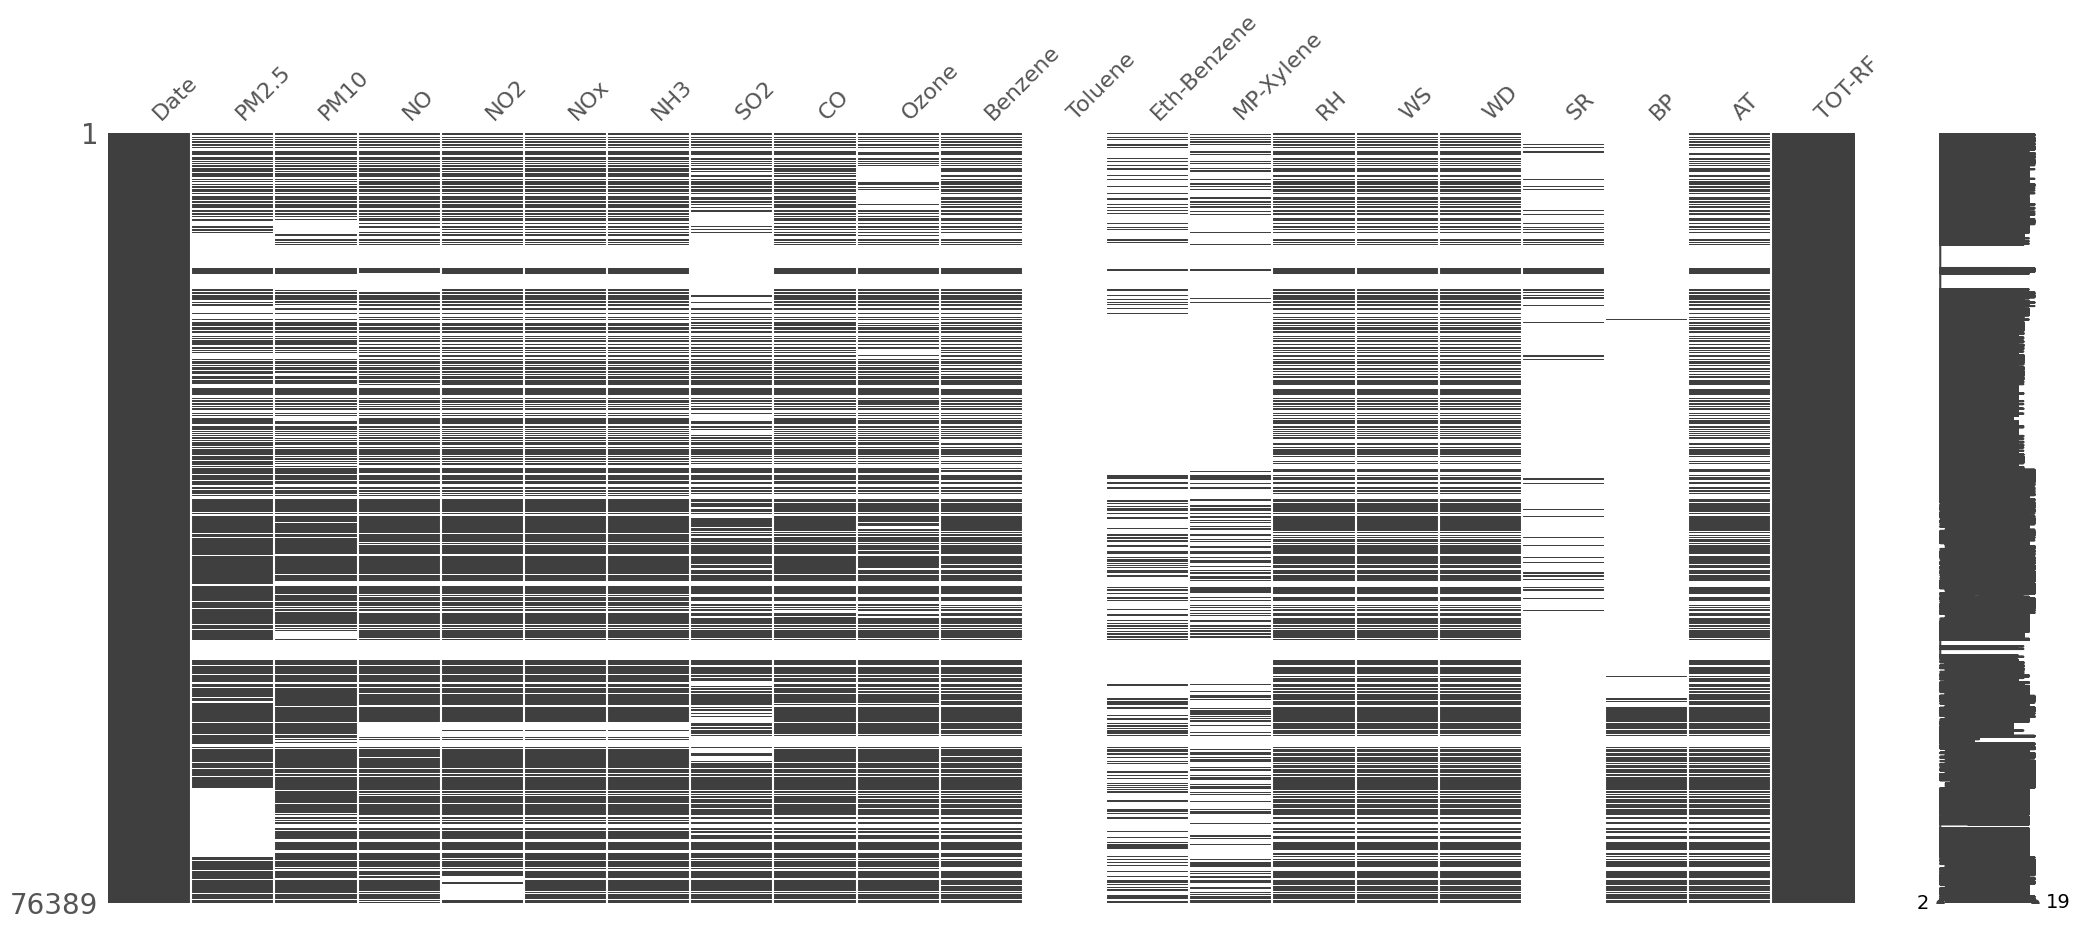

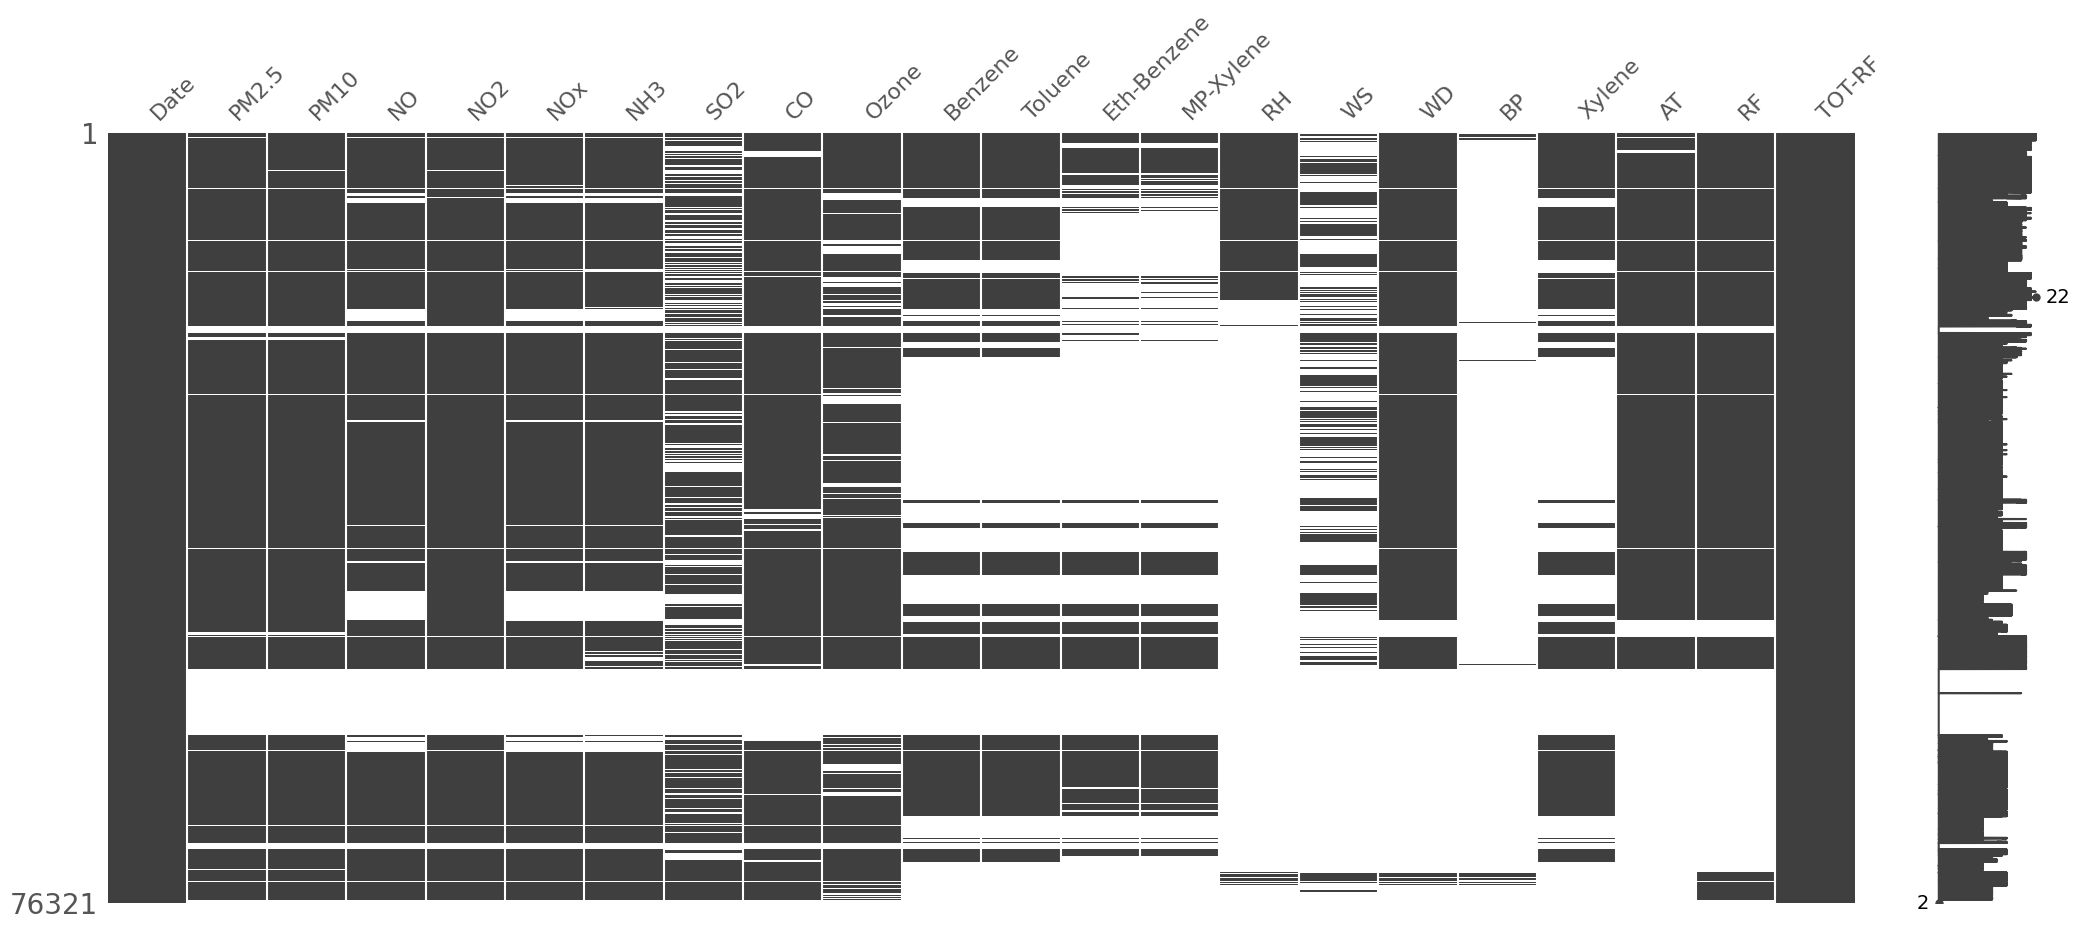

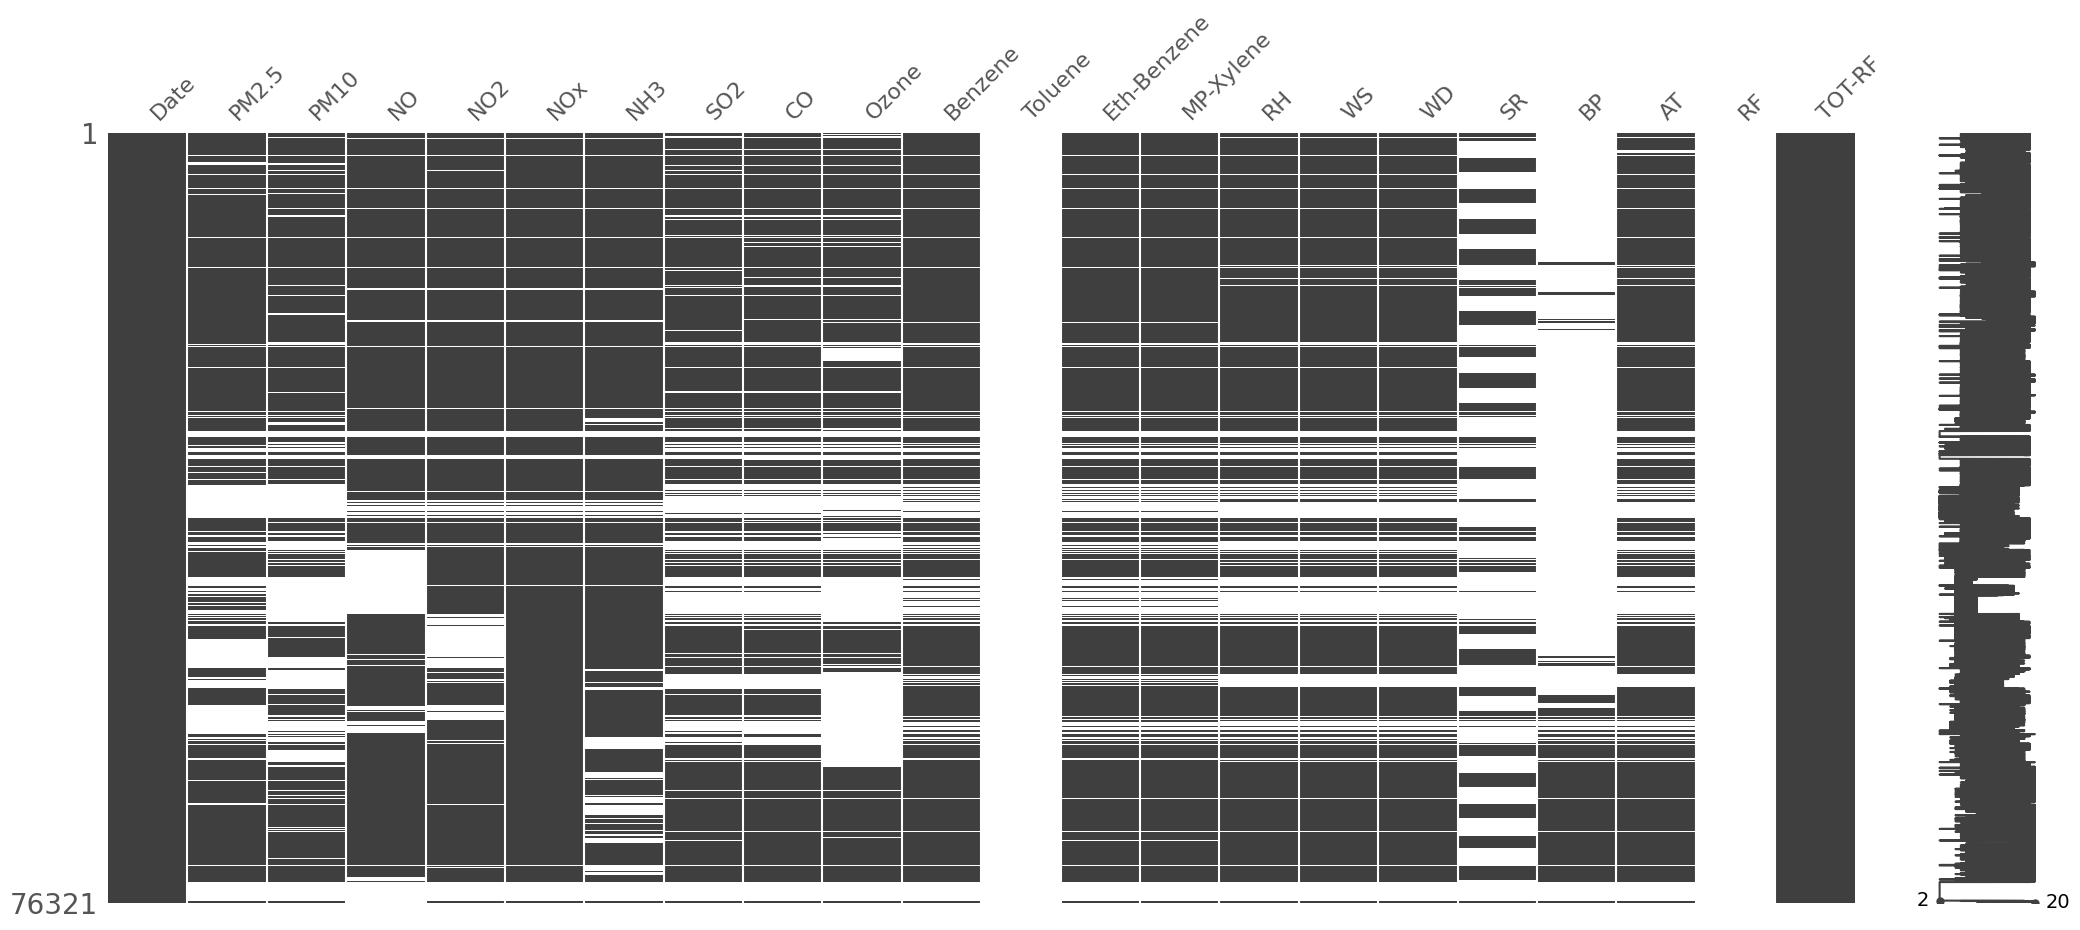

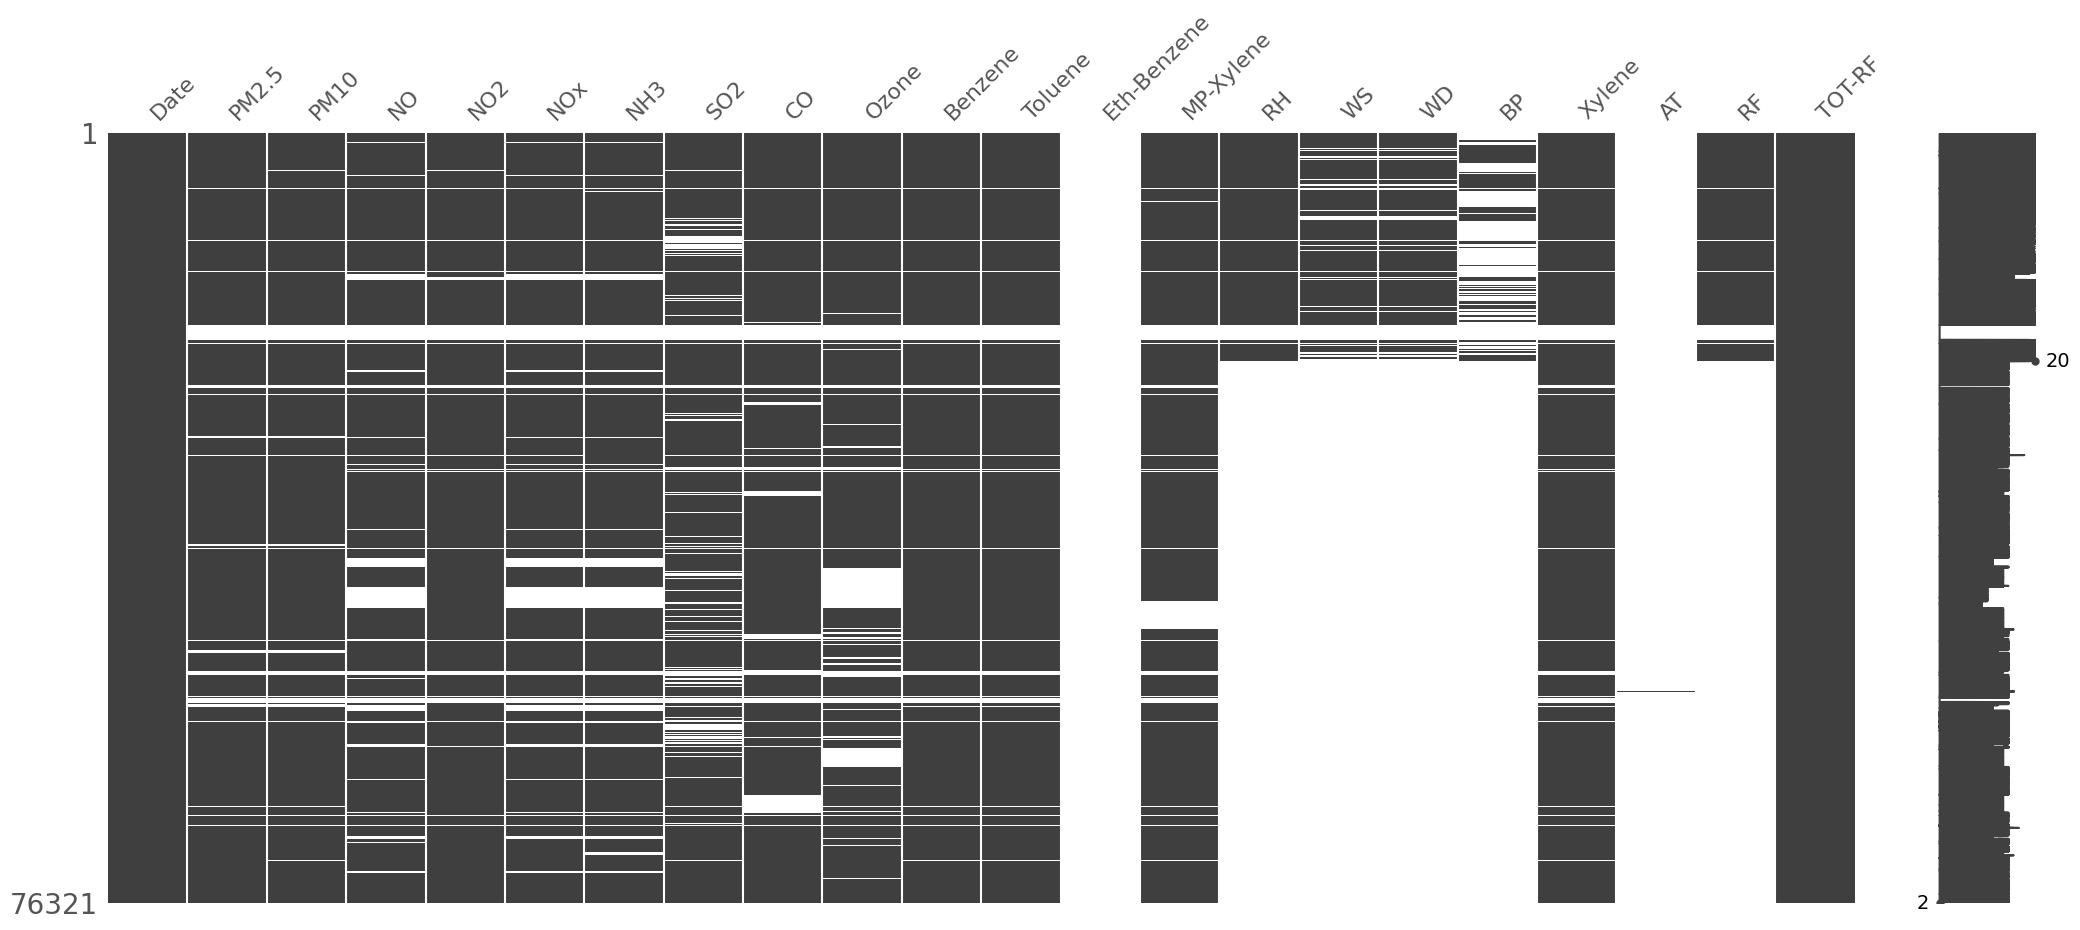

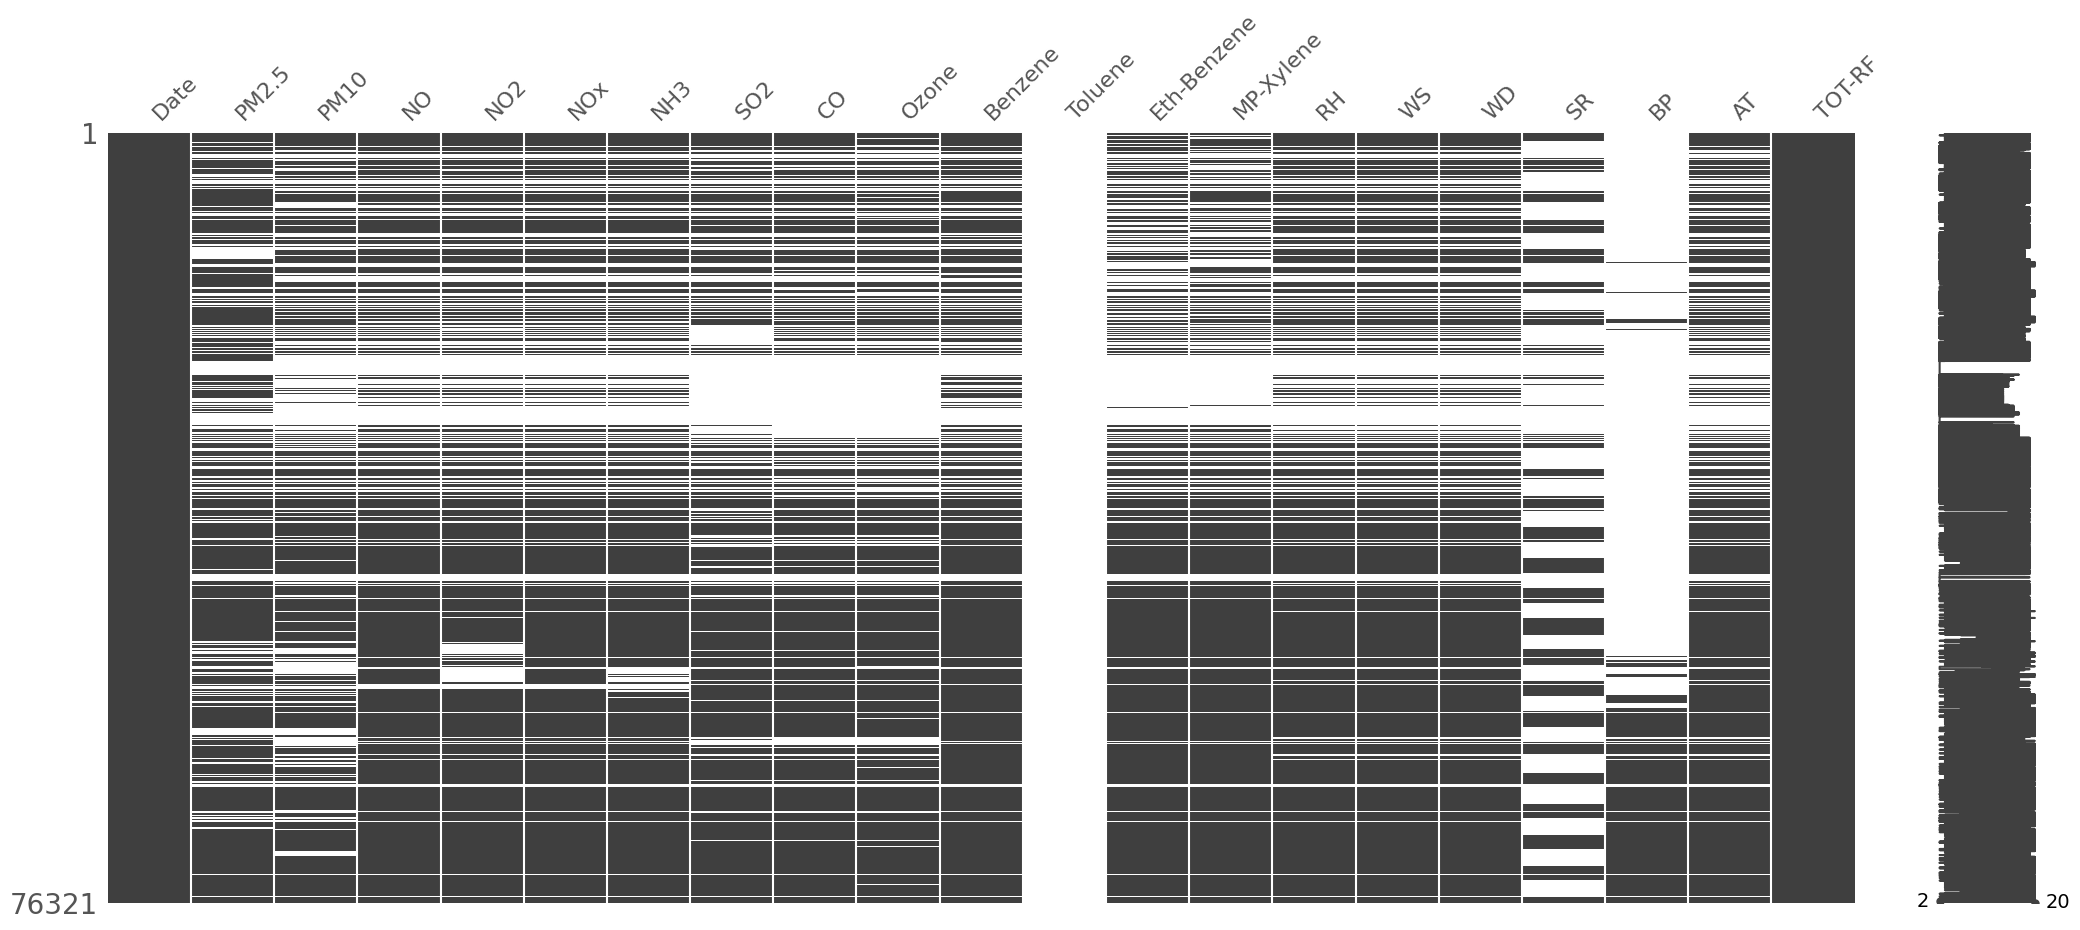

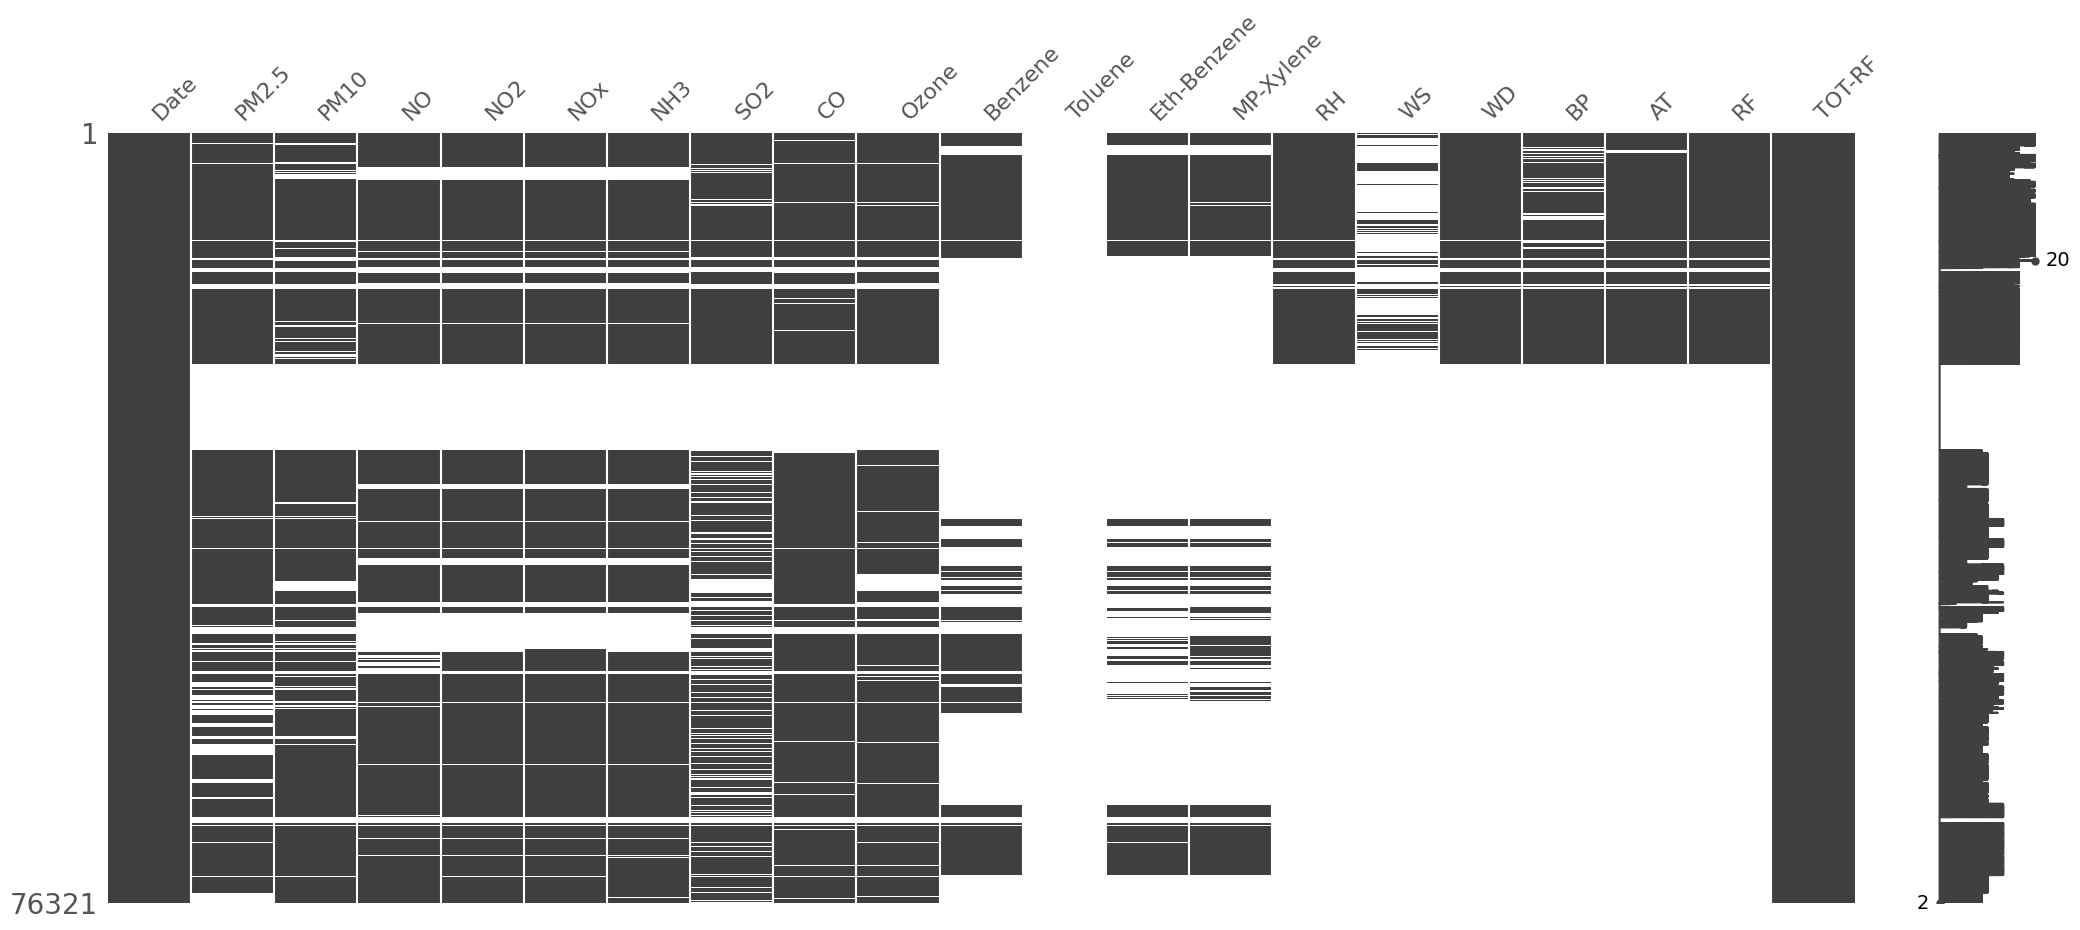

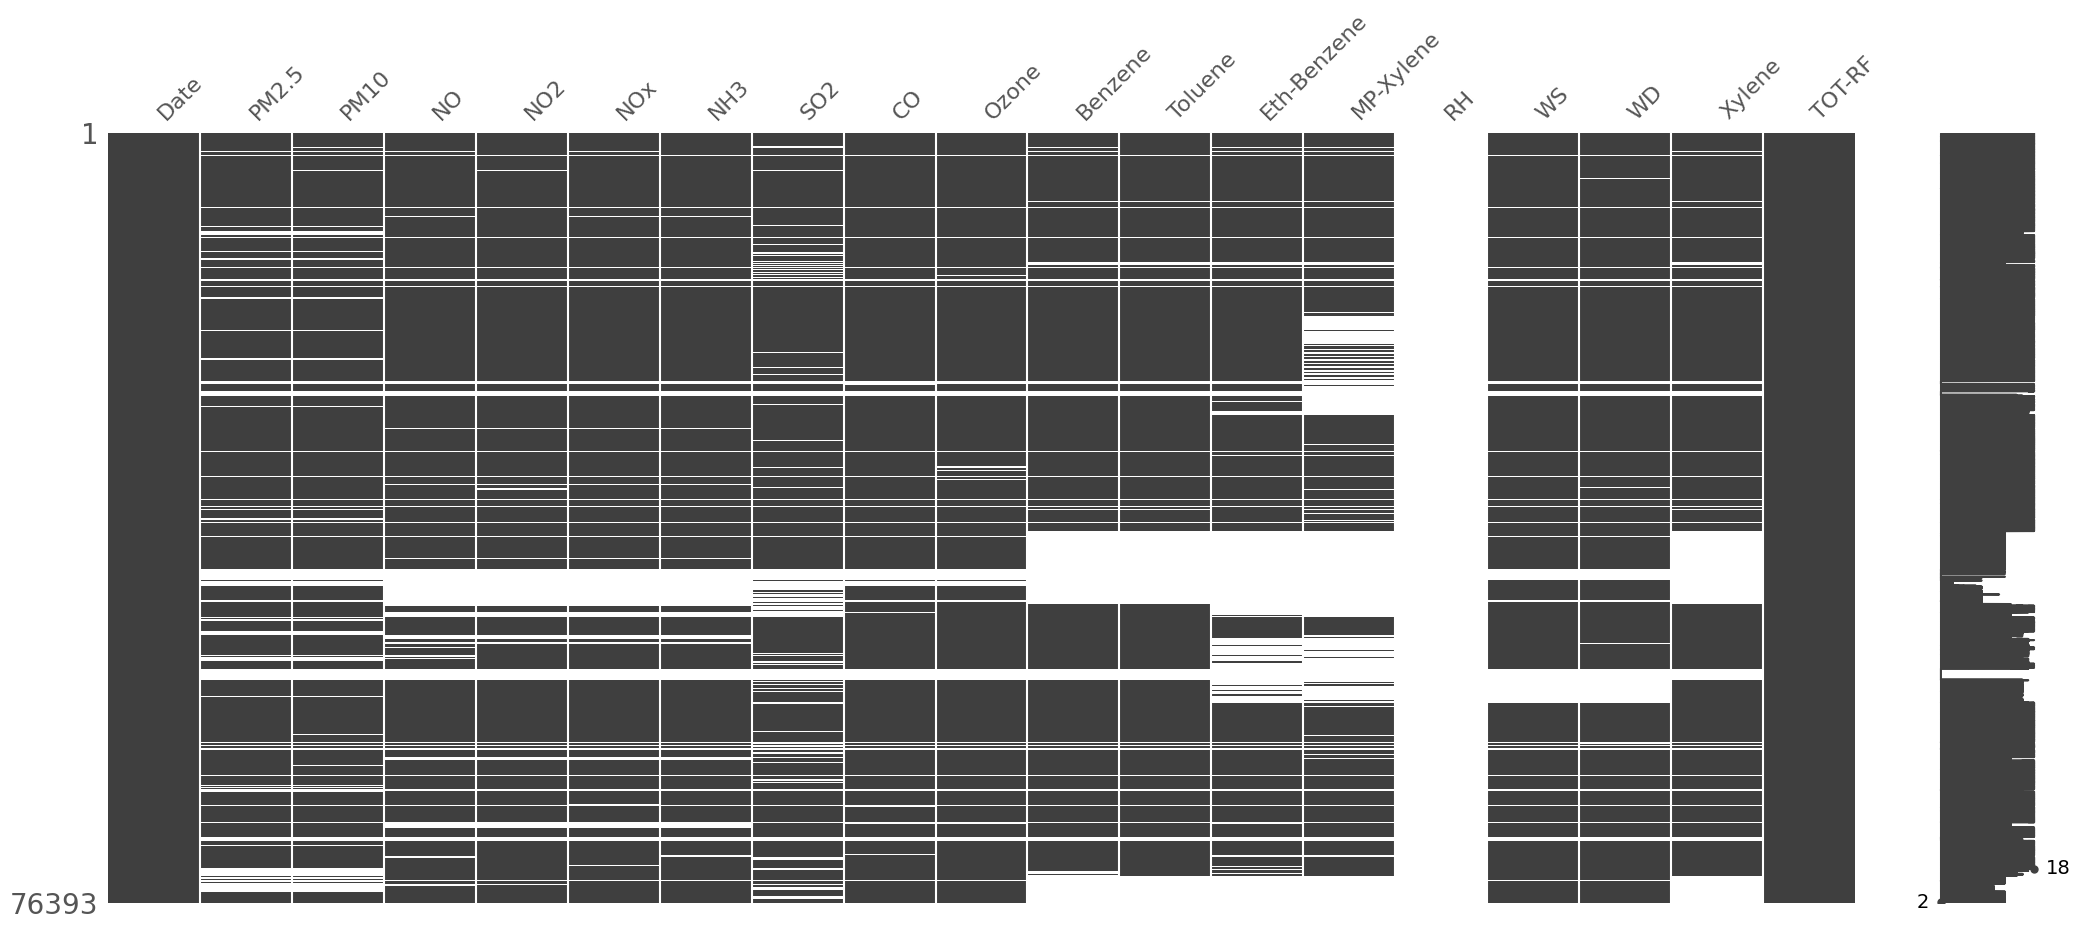

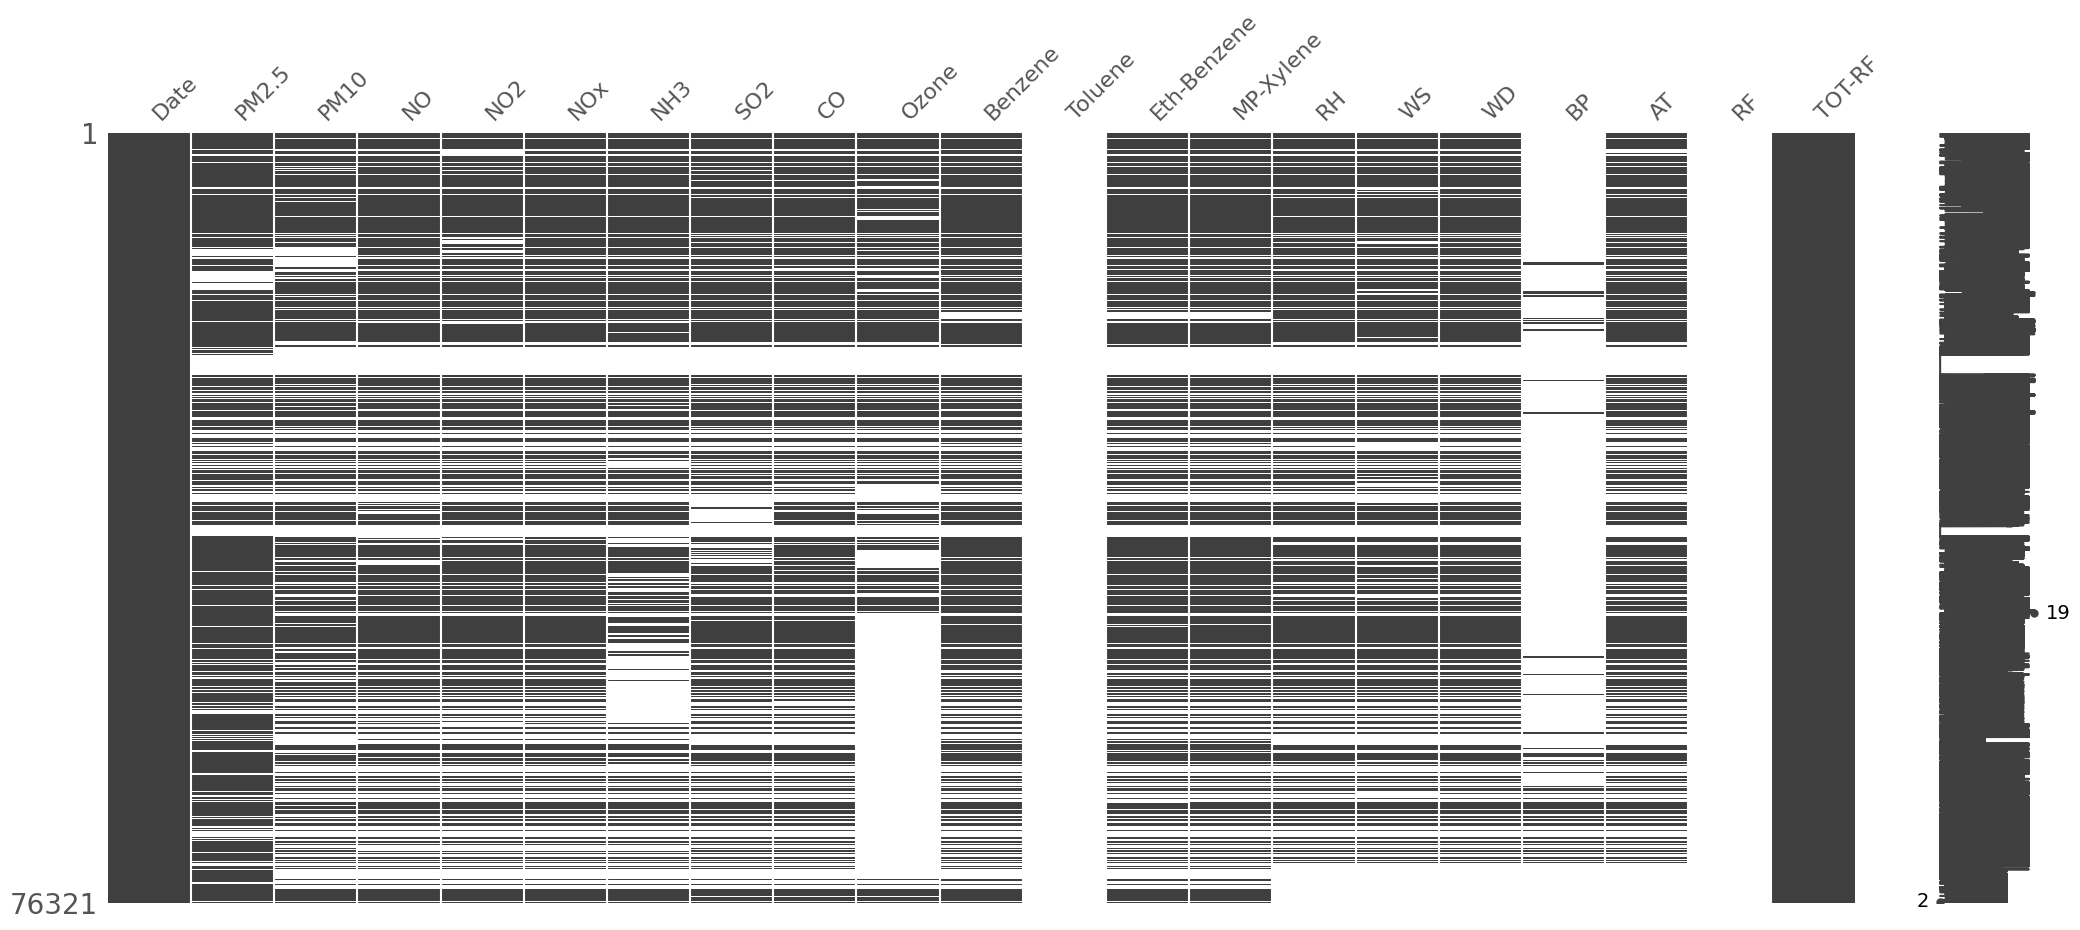

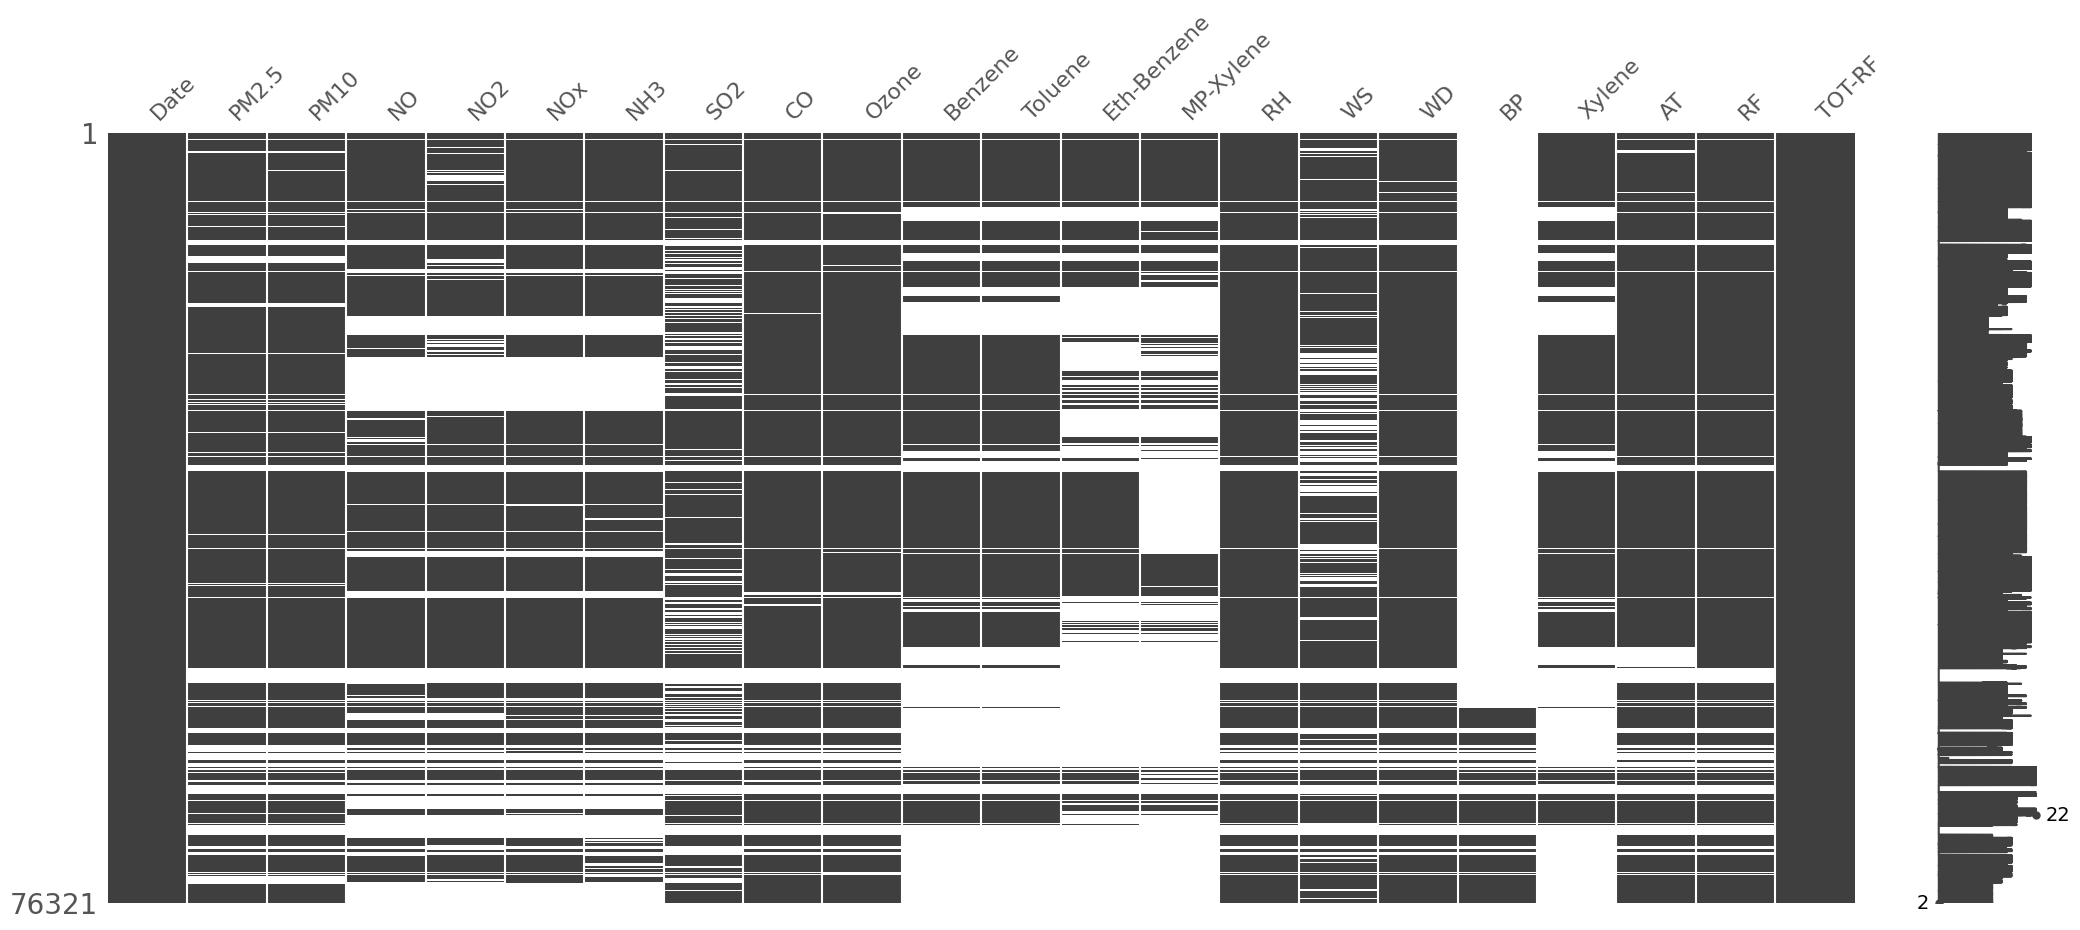

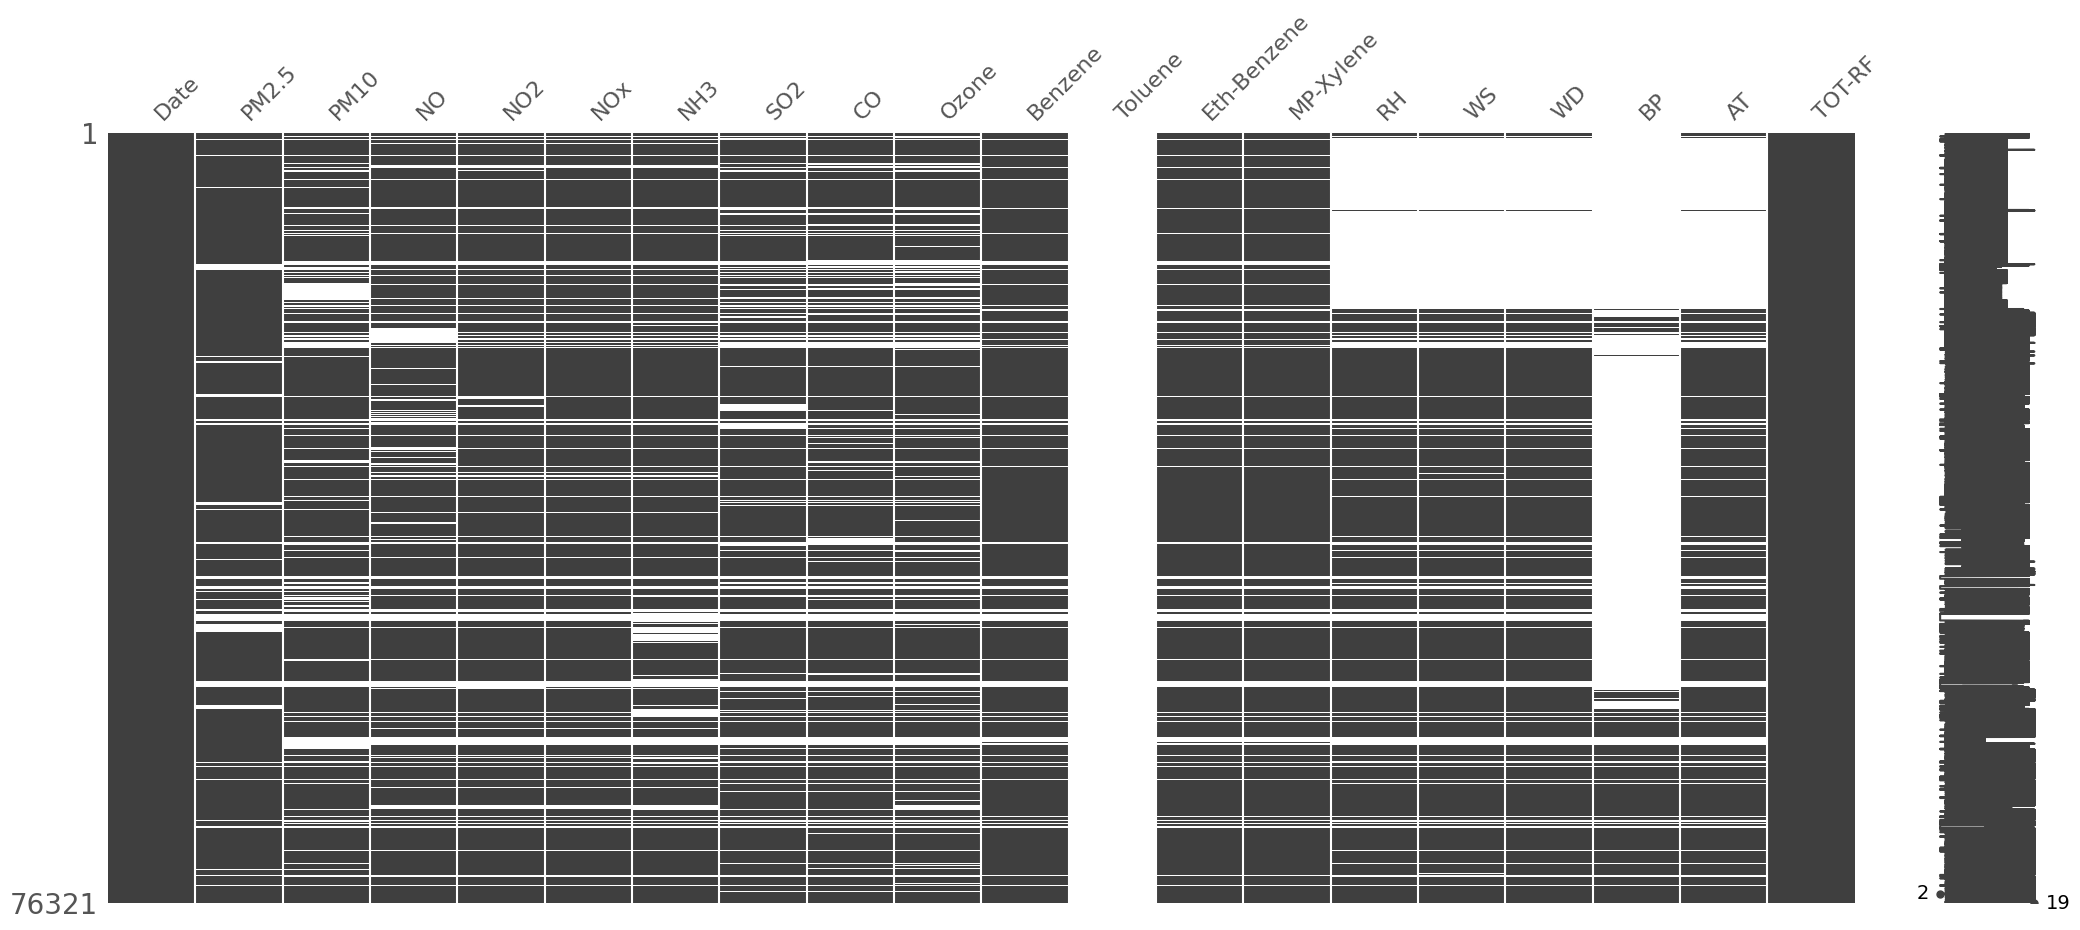

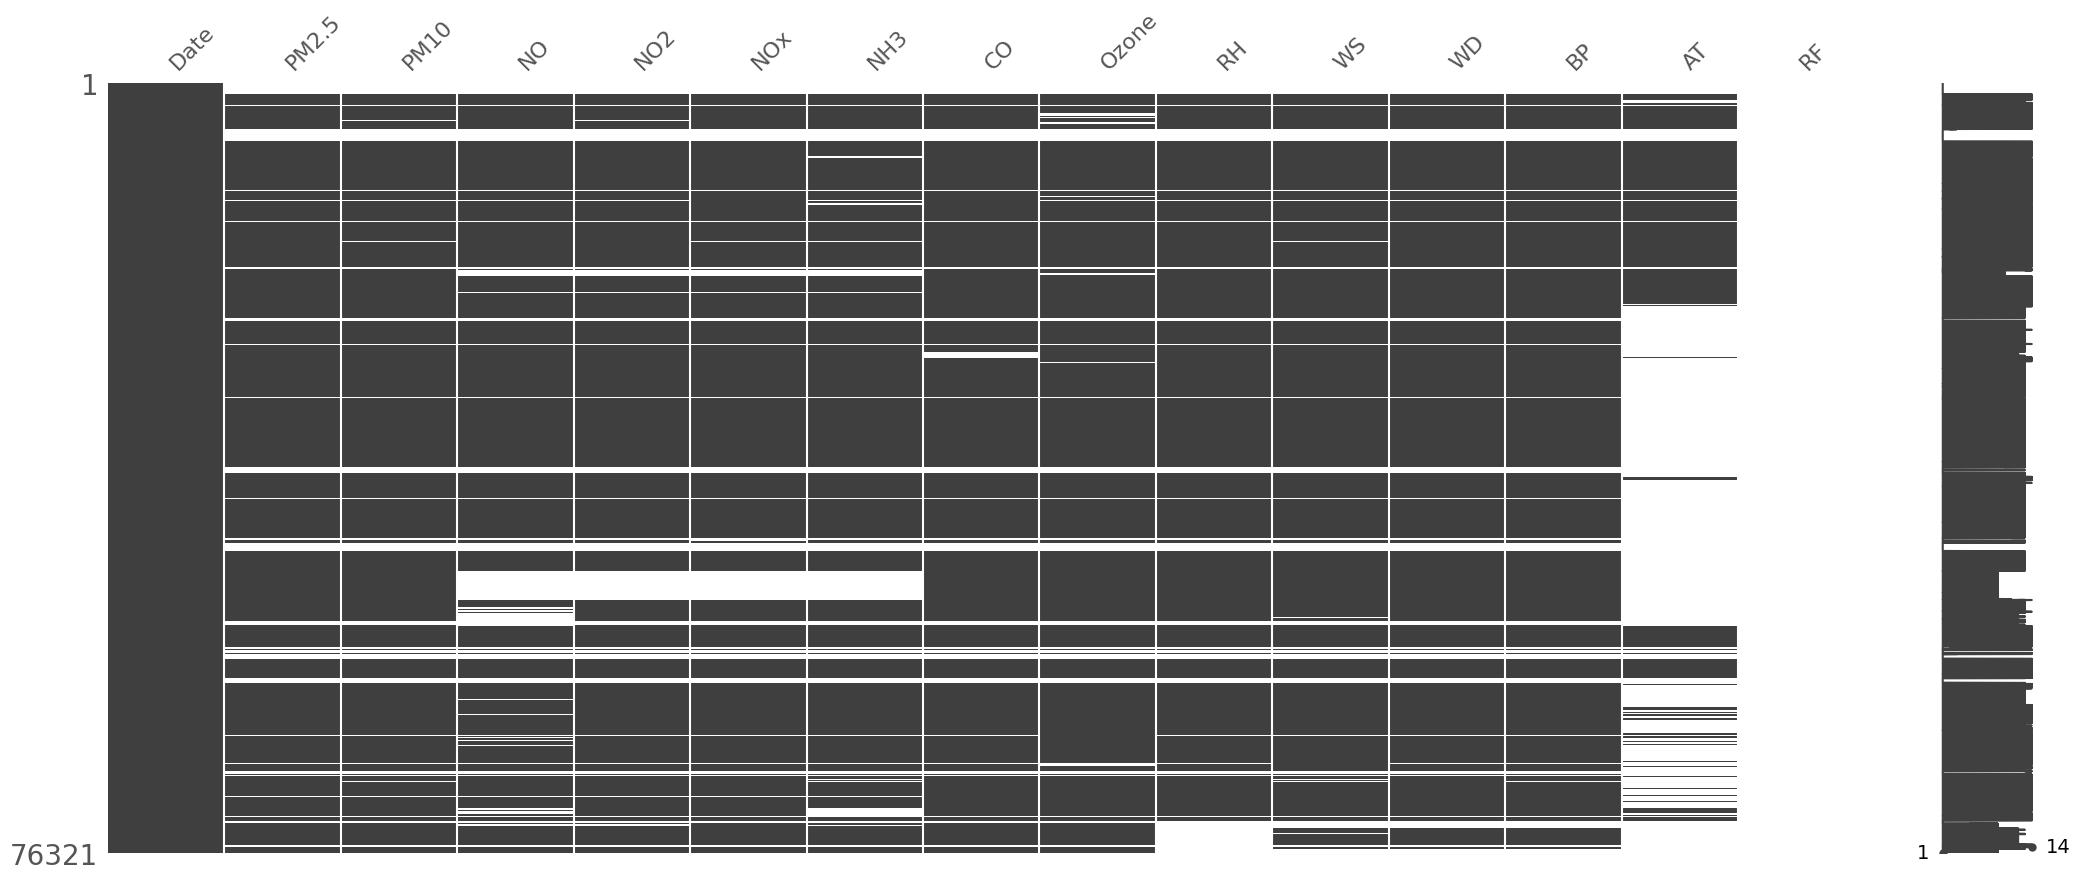

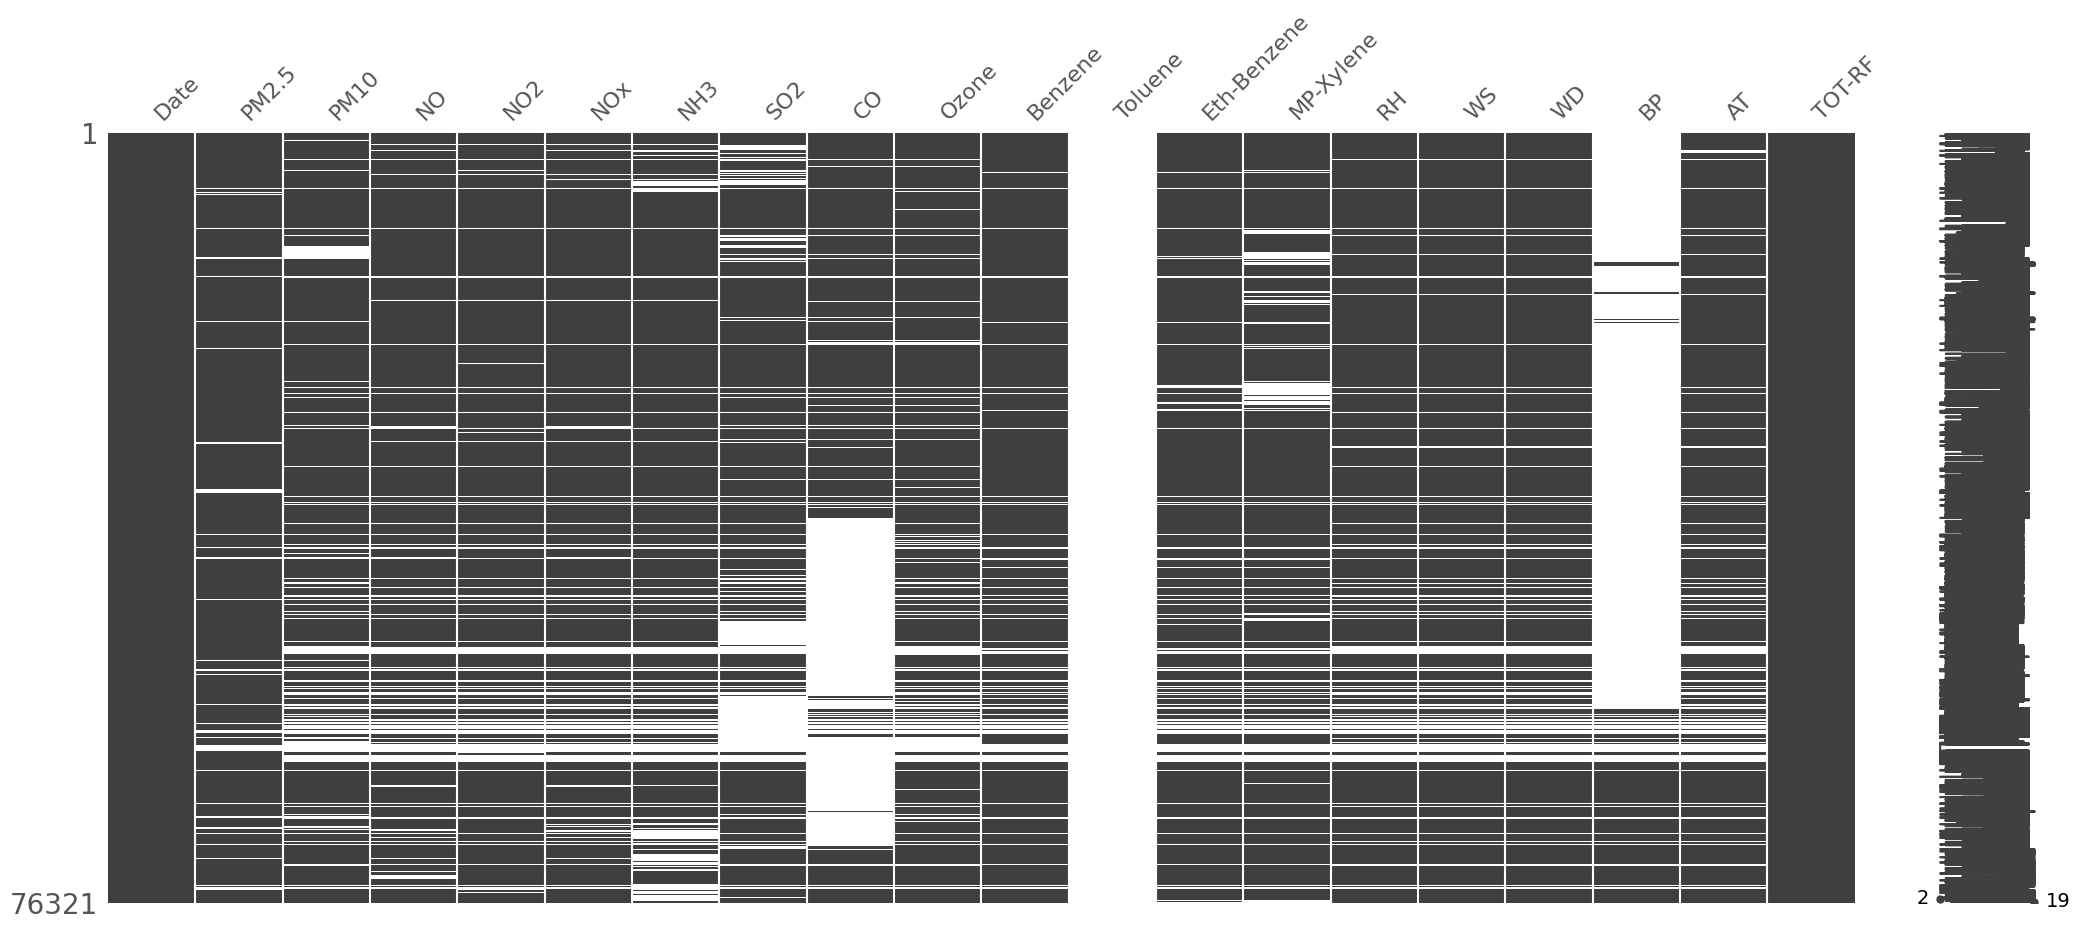

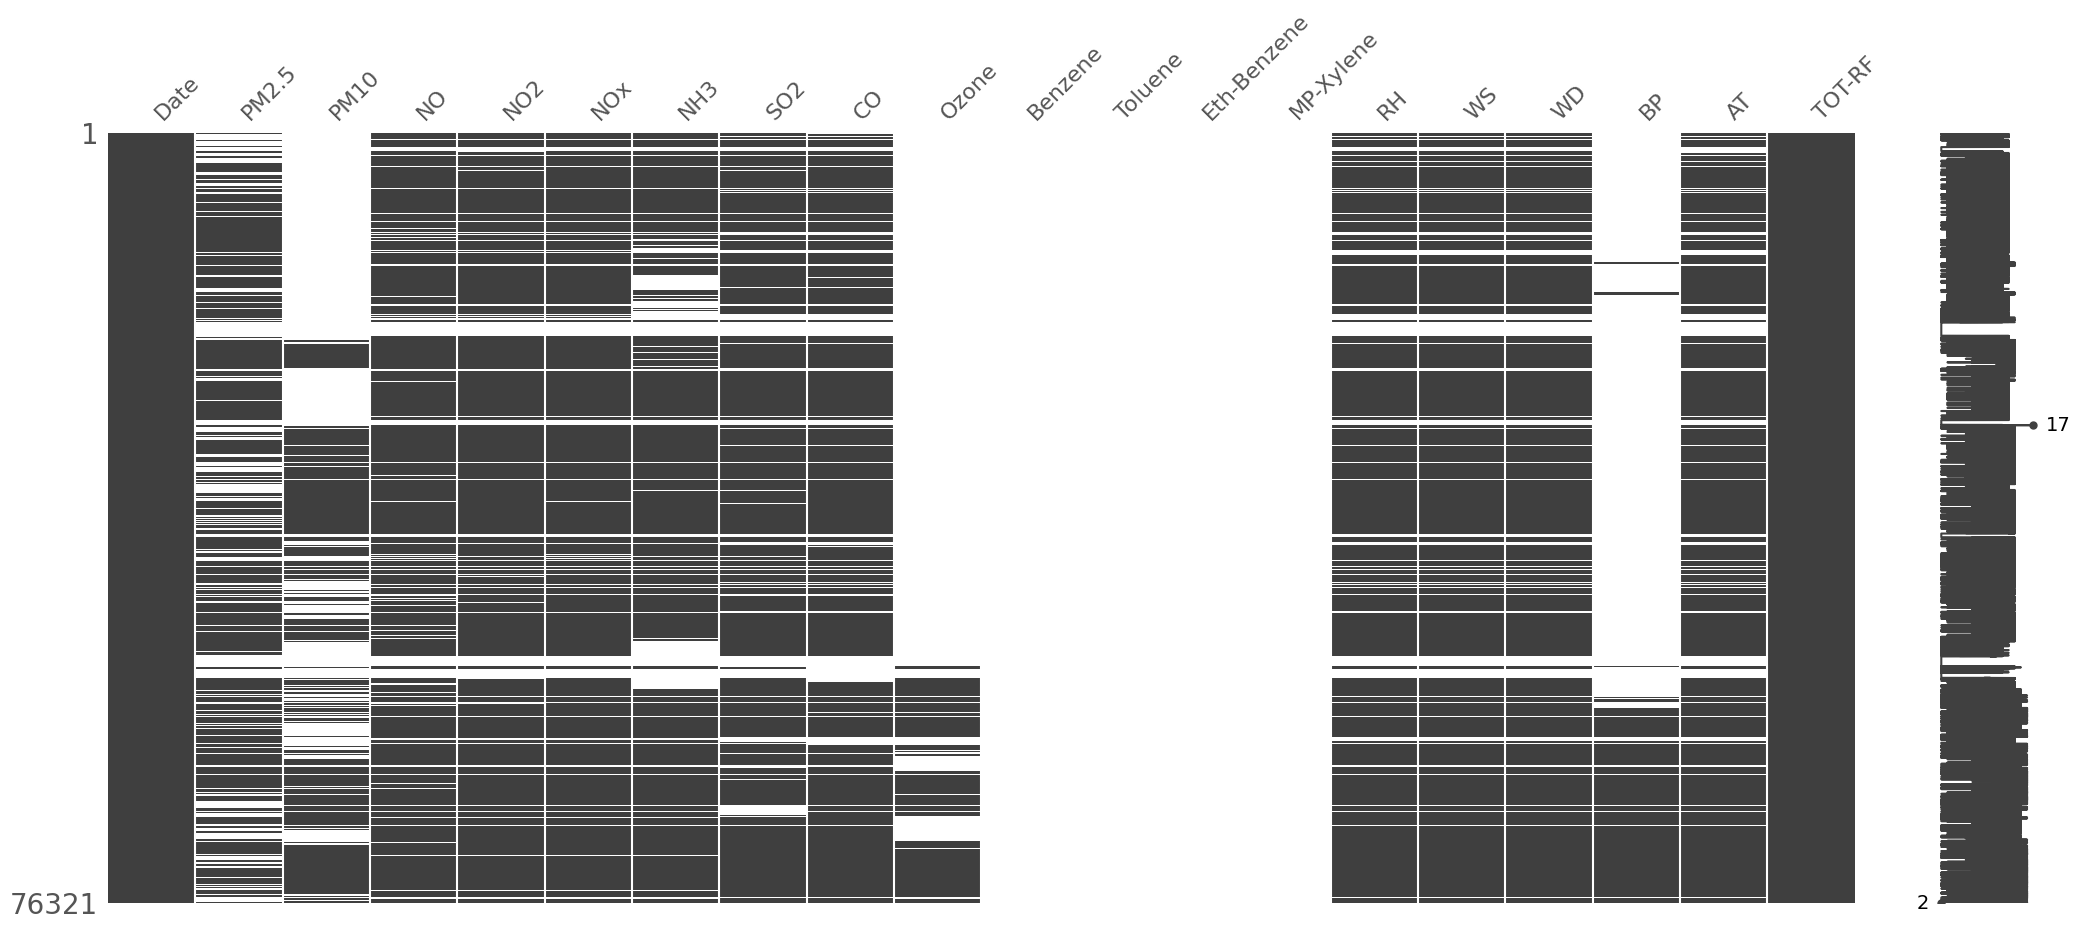

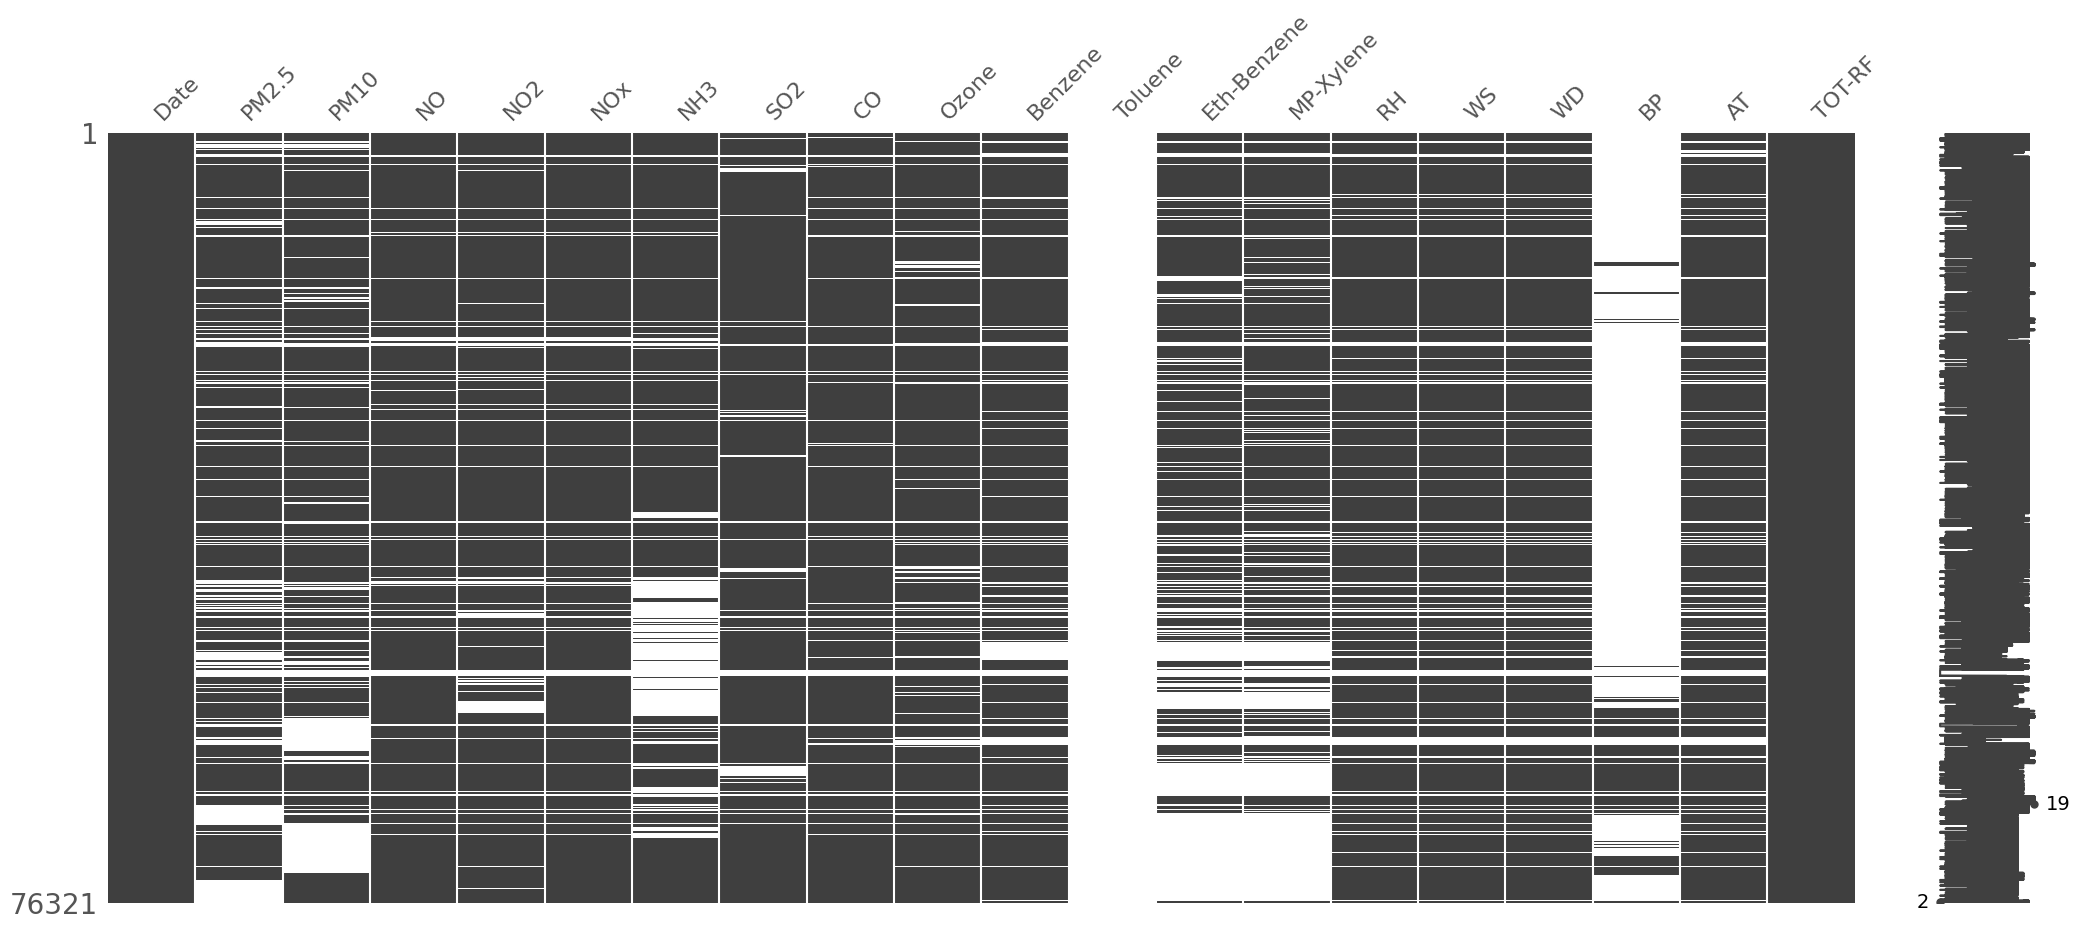

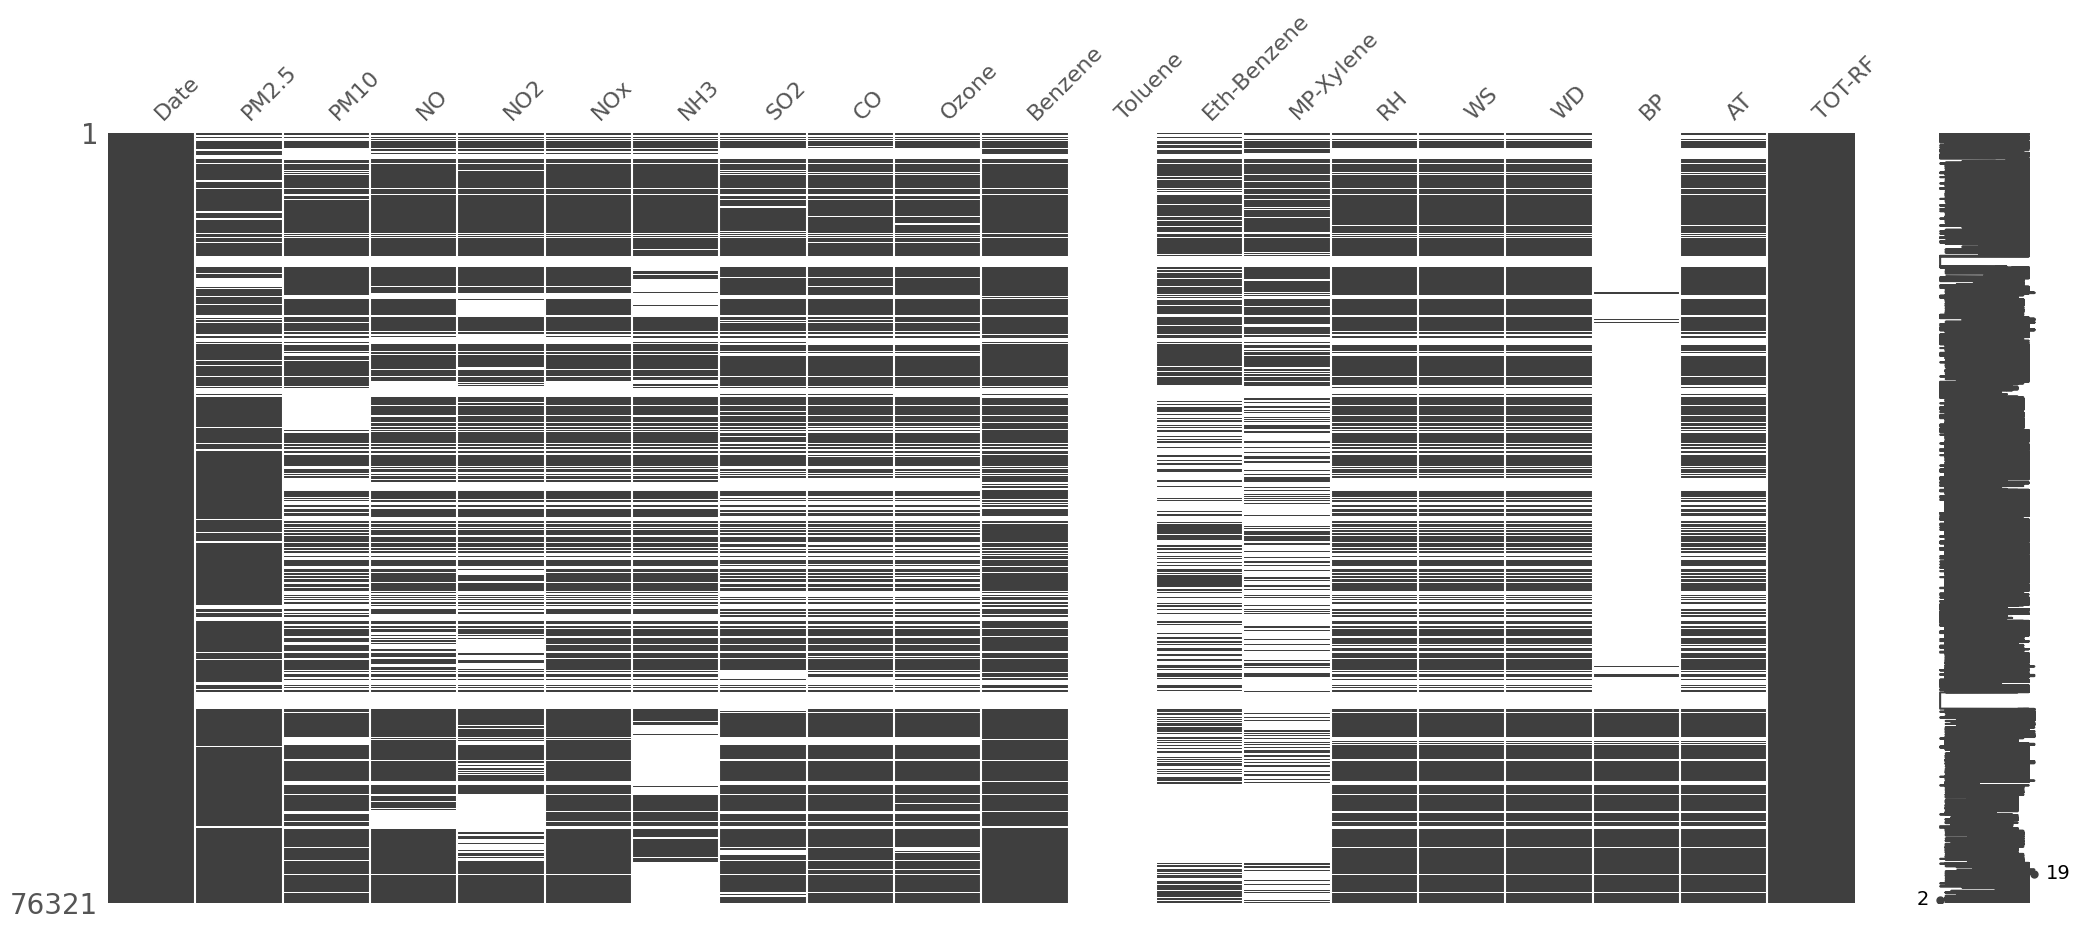

In [66]:
for keys in data_dict.keys(): 
    msno.matrix(data_dict[keys])

### Checking Outliers

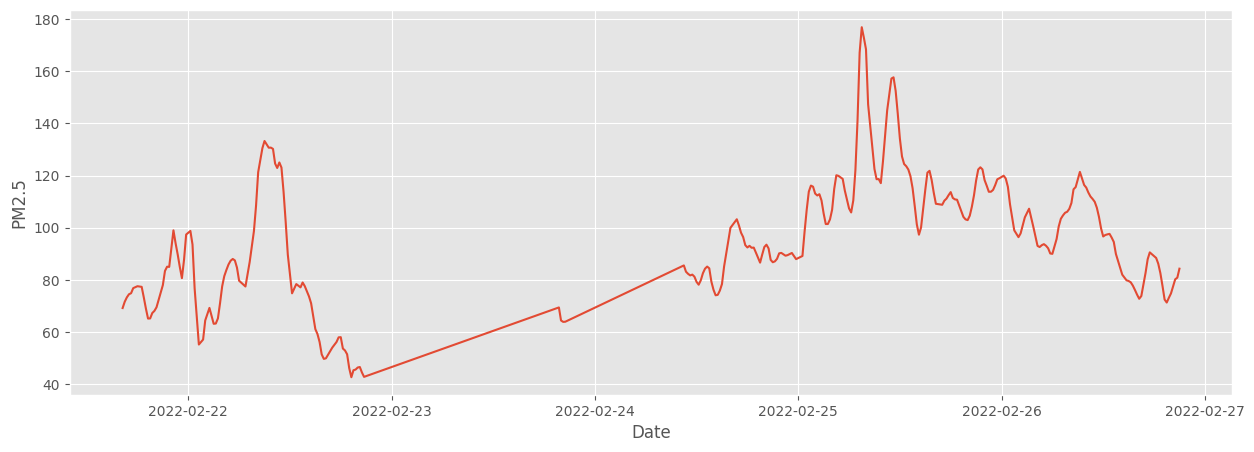

In [84]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(15, 5))
 
# drawing the plot
# Plot the responses for different events and regions

graph = sns.lineplot(x="Date", y="PM2.5", ax=ax, data=data_dict['BandraKurlaComplexMumbaiIITM'][40000:40500])


<AxesSubplot: xlabel='Date'>

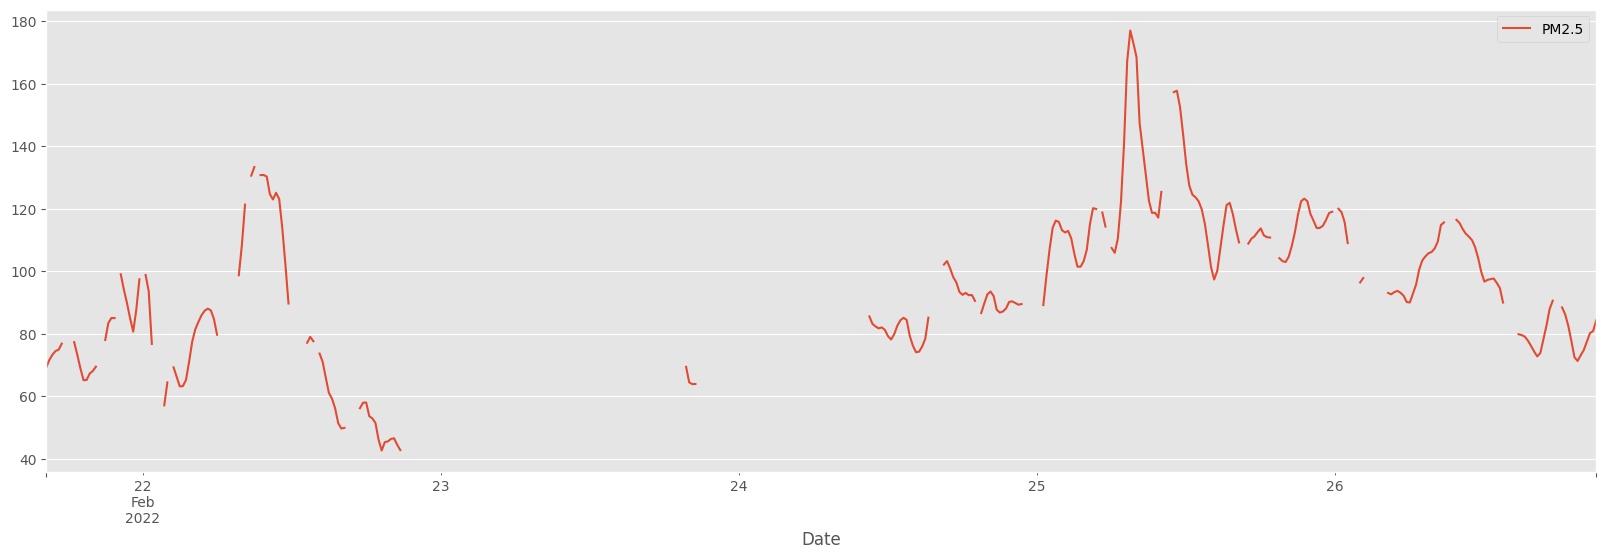

In [85]:
data_dict['BandraKurlaComplexMumbaiIITM'][['Date','PM2.5']][40000:40500].set_index('Date').plot()

<AxesSubplot: xlabel='Date'>

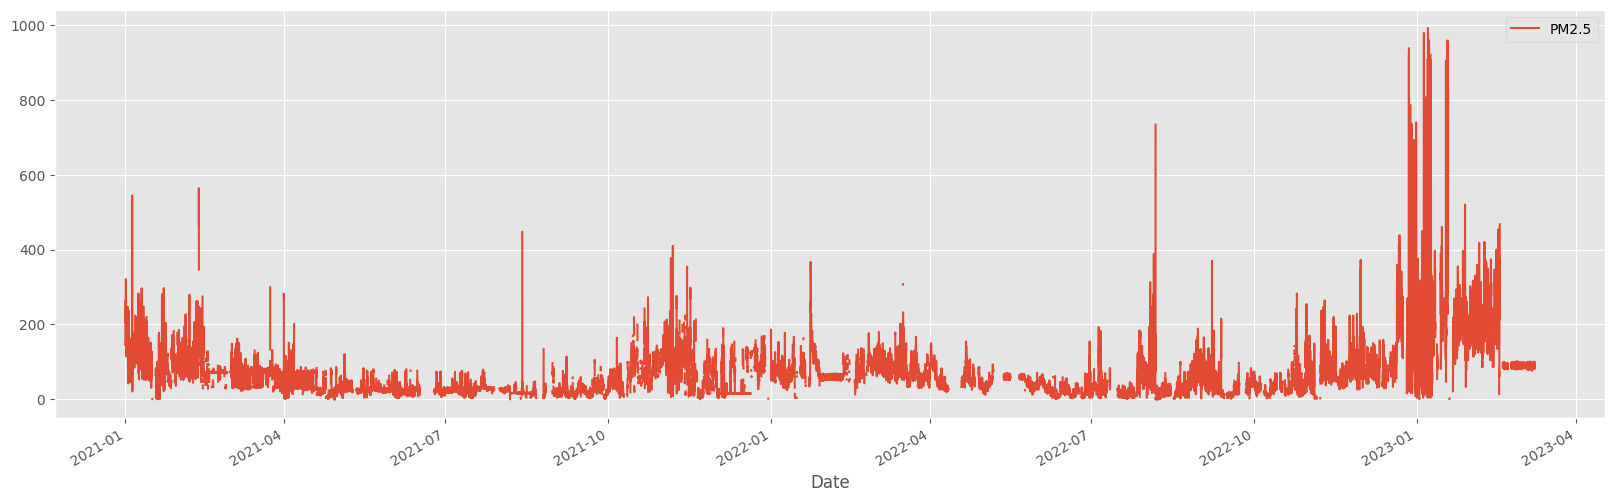

In [87]:
data_dict['BandraKurlaComplexMumbaiIITM'][['Date','PM2.5']].set_index('Date').plot()

## Imputation 

Ref: https://www.kaggle.com/code/juejuewang/handle-missing-values-in-time-series-for-beginners

To decide on the best imputation strategy, mask out some values from the original data, and impute them. Find the mean square error between the ground truth data and the imputed data. The strategy that gives the lowest MSE can be chosen. 

Note, the final decision will be based on model performance. This is an ad-hoc method until we start modelling.

### Create a masked dataset 

In [139]:
df = data_dict['KurlaMumbaiMPCB']
df_pm25 = df[['Date', 'PM2.5']].copy()

Missing data visualised for a sample

<AxesSubplot: xlabel='Date'>

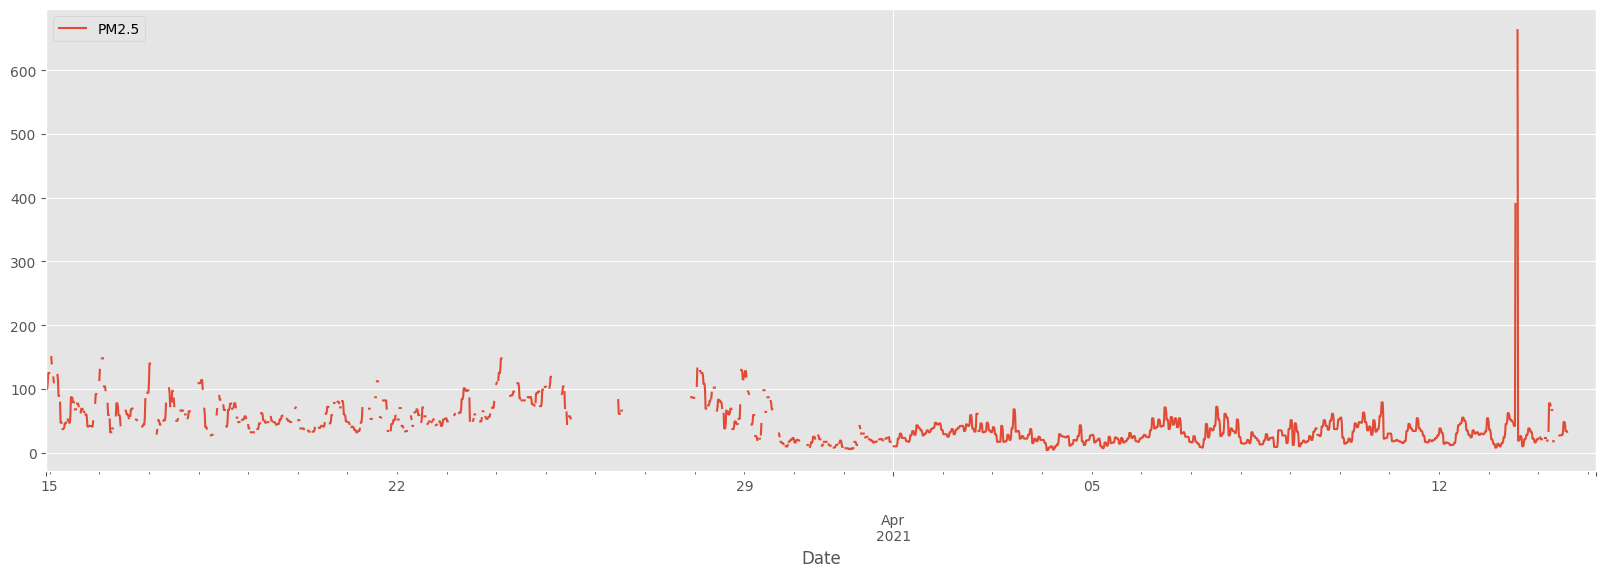

In [140]:
df_pm25[7000:10000].set_index('Date').plot()

Randomly set 10% of data as missing.

In [141]:
# get the list of indices of non-empty rows 
res = np.where(np.isnan(df['PM2.5']) == False)[0]
random.seed(42)
res_mask = random.sample(list(res), int(0.1*len(res)))
df_pm25_masked = df_pm25.copy()
df_pm25_masked.loc[res_mask, 'PM2.5'] = np.NaN

### Median Imputation

In [142]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
col_pm = df_pm25_masked['PM2.5'].values.reshape(-1, 1)
imputed_col_pm = imp.fit_transform(col_pm)
df_pm25_imputed = df_pm25_masked.copy()
df_pm25_imputed.loc[:,'PM2.5'] = imputed_col_pm

<AxesSubplot: xlabel='Date'>

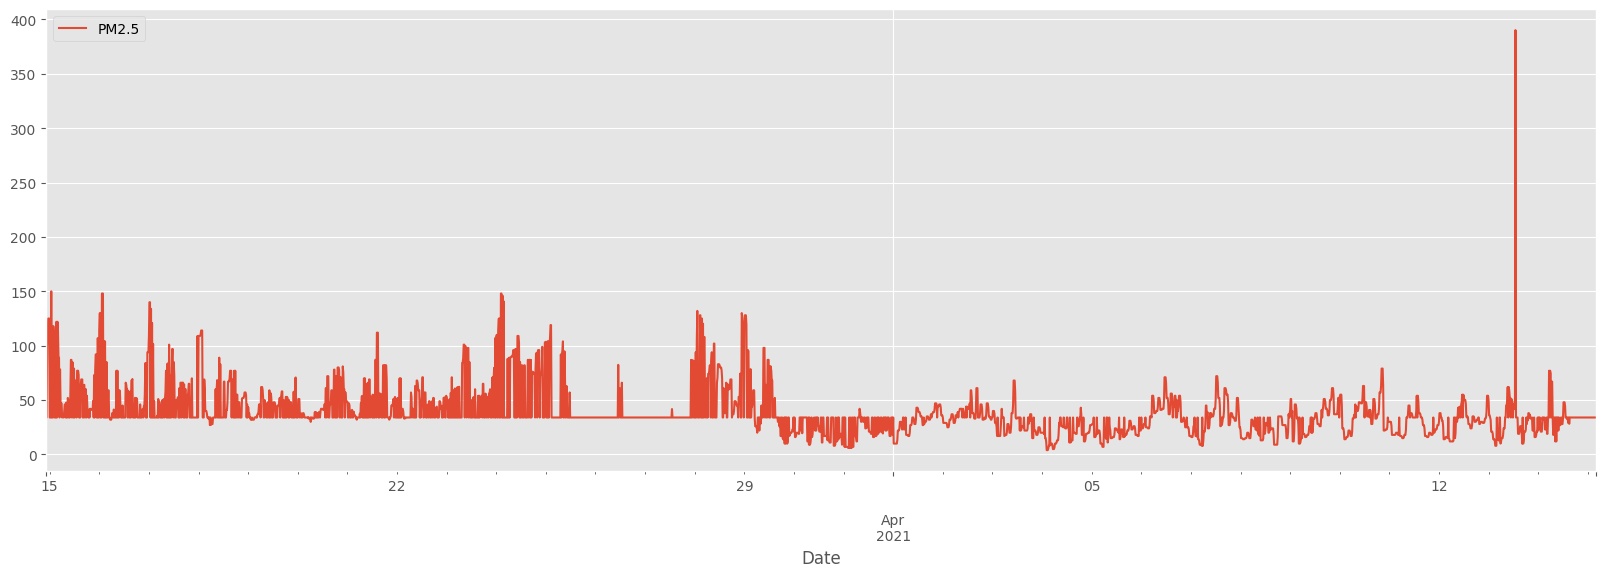

In [143]:
df_pm25_imputed[7000:10000].set_index('Date').plot()

In [144]:
x1 = df_pm25.loc[res_mask, 'PM2.5']
x2 = df_pm25_imputed.loc[res_mask, 'PM2.5']
mse = mean_squared_error(x1, x2)
mse

1787.7371824216577

### Mean Imputation

In [145]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_col_pm = imp.fit_transform(col_pm)
df_pm25_imputed.loc[:,'PM2.5'] = imputed_col_pm

<AxesSubplot: xlabel='Date'>

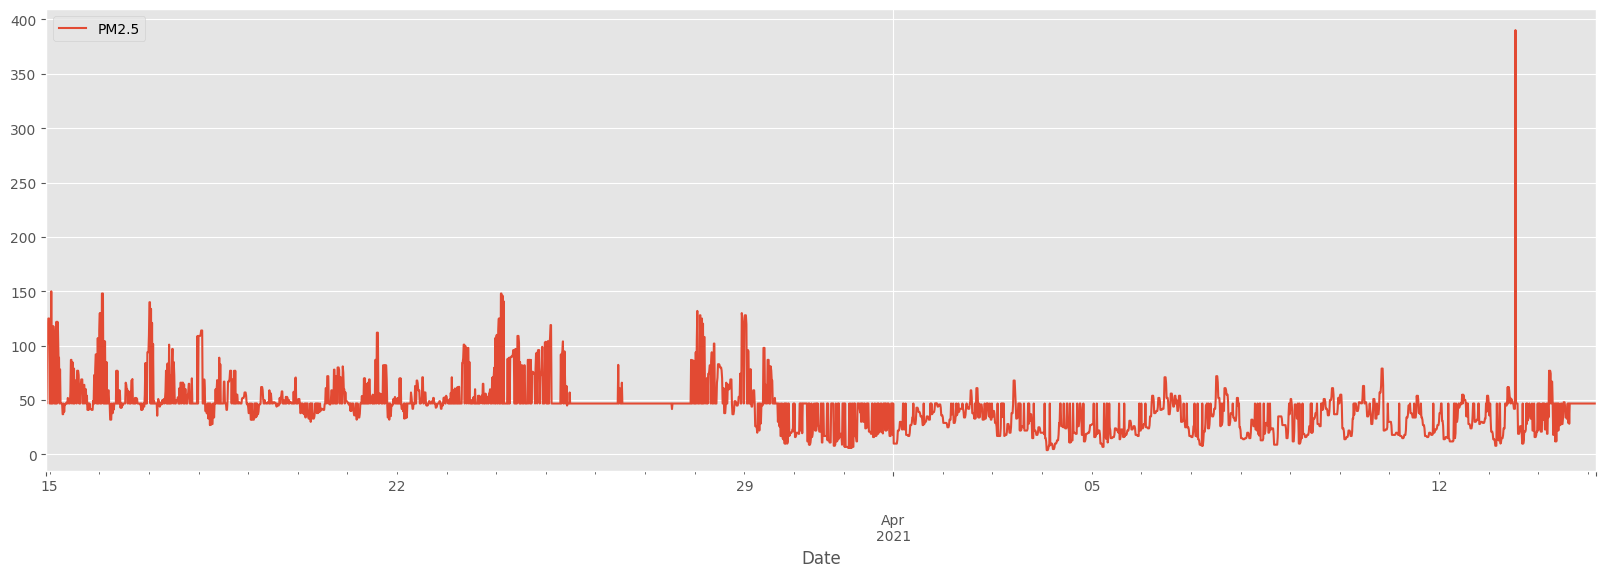

In [146]:
df_pm25_imputed[7000:10000].set_index('Date').plot()

In [147]:
x1 = df_pm25.loc[res_mask, 'PM2.5']
x2 = df_pm25_imputed.loc[res_mask, 'PM2.5']
mse = mean_squared_error(x1, x2)
mse

1603.4974083671582

### LOCF (Last Observation Carry Forward) or Forward Fill Imputation

In [148]:
df_pm25_imputed = df_pm25_masked.ffill()

<AxesSubplot: xlabel='Date'>

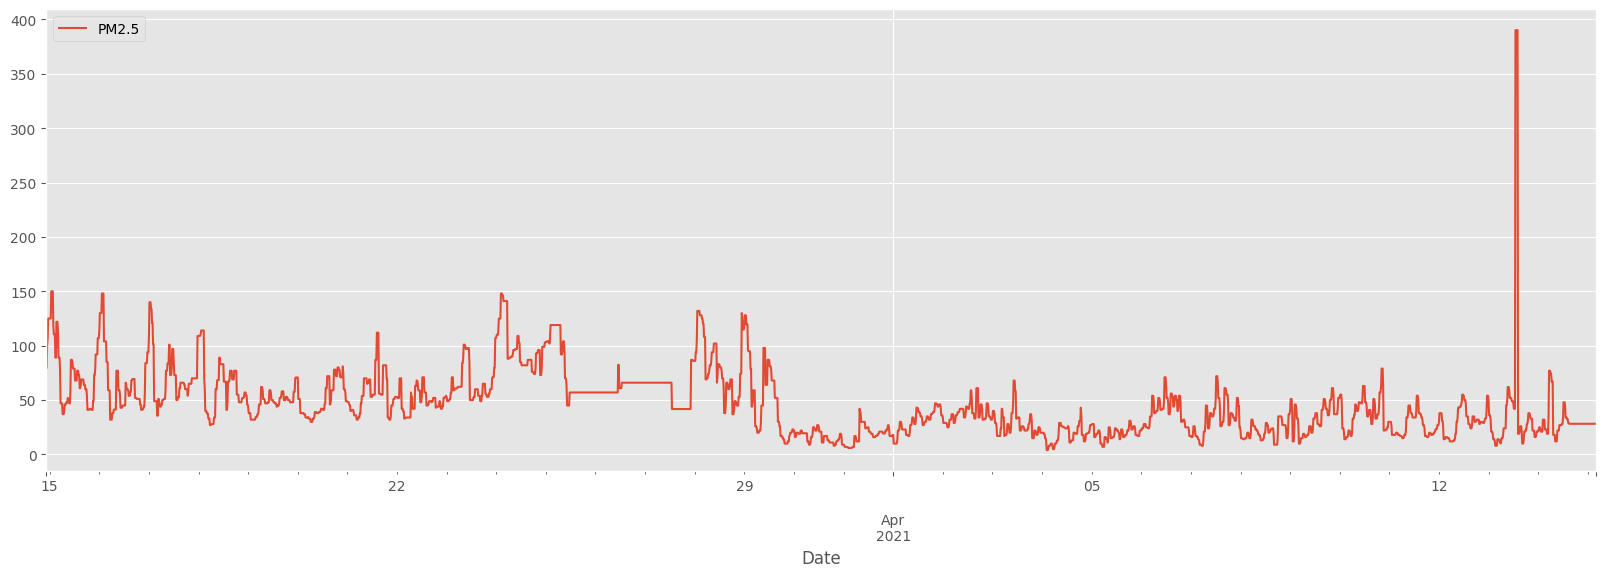

In [149]:
df_pm25_imputed[7000:10000].set_index('Date').plot()

In [150]:
x1 = df_pm25.loc[res_mask, 'PM2.5']
x2 = df_pm25_imputed.loc[res_mask, 'PM2.5']
mse = mean_squared_error(x1, x2)
mse

271.3146165585017

### NOBF (Next Observation Bring Forward) or Backward Fill Imputation

In [151]:
df_pm25_imputed = df_pm25_masked.bfill()

<AxesSubplot: xlabel='Date'>

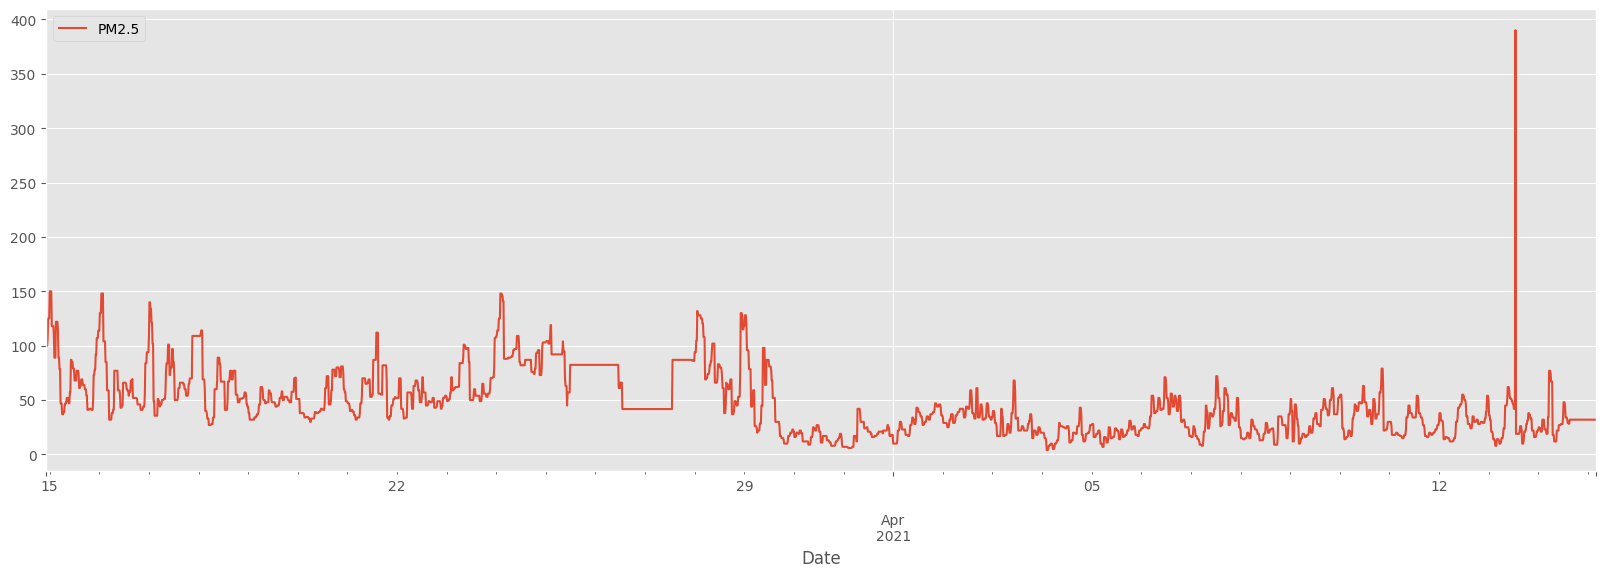

In [152]:
df_pm25_imputed[7000:10000].set_index('Date').plot()

In [153]:
x1 = df_pm25.loc[res_mask, 'PM2.5']
x2 = df_pm25_imputed.loc[res_mask, 'PM2.5']
mse = mean_squared_error(x1, x2)
mse

280.6047127572779

### Linear interpolation

In [154]:
ts = pd.Series(df_pm25_masked['PM2.5'])
ts_interpolated = ts.interpolate(method='linear', limit_direction='forward')
df_pm25_imputed.loc[:,'PM2.5'] = ts_interpolated

<AxesSubplot: xlabel='Date'>

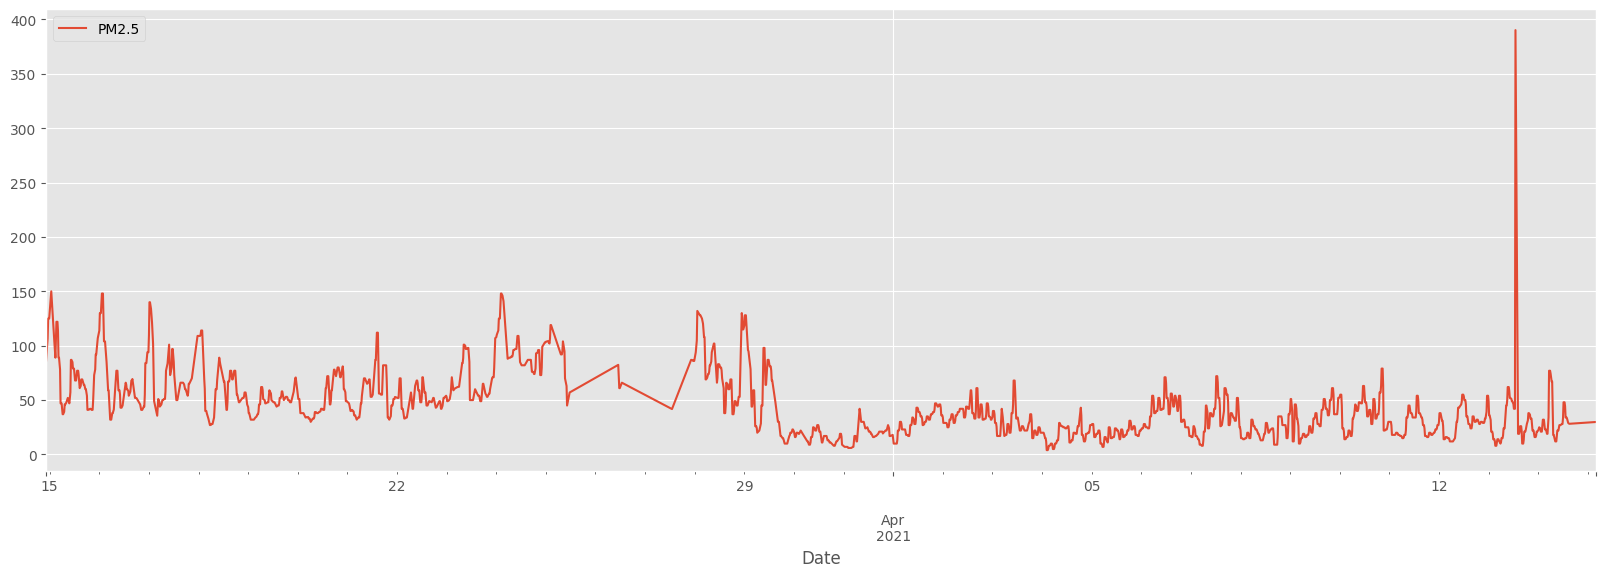

In [155]:
df_pm25_imputed[7000:10000].set_index('Date').plot()

In [156]:
x1 = df_pm25.loc[res_mask, 'PM2.5']
x2 = df_pm25_imputed.loc[res_mask, 'PM2.5']
mse = mean_squared_error(x1, x2)
mse

144.91196256333657

Impute MSE for all stations

In [157]:
def impute_eval(df):
    df_mse = pd.DataFrame(index=df.columns[1:], columns=['Median', 'Mean', 'Forward Fill', 'Backward Fill', 'Linear Interpolation'])

    for i in range(len(df.columns)-1): 
        col = df.columns[i+1]
        # create masked data
        df_col = df[['Date', col]].copy()
       
        # get the list of indices of non-empty rows 
        res = np.where(np.isnan(df[col]) == False)[0]
        if len(res) == 0: 
            continue

        random.seed(42)
        res_mask = random.sample(list(res), int(0.1*len(res)))
        if len(res_mask) == 0: 
            continue
        
        df_col_masked = df_col.copy()
        df_col_masked.loc[res_mask, col] = np.NaN

        df_col_imputed = df_col_masked.copy()

        #median imputation
        imp = SimpleImputer(missing_values=np.nan, strategy='median')
        col_val = df_col_masked[col].values.reshape(-1, 1)
        imputed_col_val = imp.fit_transform(col_val)
        df_col_imputed.loc[:,col] = imputed_col_val

        x1 = df_col.loc[res_mask, col]
        x2 = df_col_imputed.loc[res_mask, col]
        mse_median = mean_squared_error(x1, x2)

        #mean imputation 
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        col_val = df_col_masked[col].values.reshape(-1, 1)
        imputed_col_val = imp.fit_transform(col_val)
        df_col_imputed.loc[:,col] = imputed_col_val

        x1 = df_col.loc[res_mask, col]
        x2 = df_col_imputed.loc[res_mask, col]
        mse_mean = mean_squared_error(x1, x2)

        #forward fill
        df_col_imputed = df_col_masked.ffill()
        df_col_imputed = df_col_imputed.replace(np.NaN, 0)
        x1 = df_col.loc[res_mask, col]
        x2 = df_col_imputed.loc[res_mask, col]
        mse_fwdfill = mean_squared_error(x1, x2)

        #backward fill 
        df_col_imputed = df_col_masked.bfill()
        df_col_imputed = df_col_imputed.replace(np.NaN, 0)
        x1 = df_col.loc[res_mask, col]
        x2 = df_col_imputed.loc[res_mask, col]
        mse_bwdfill = mean_squared_error(x1, x2)

        #linear interpolation
        ts = pd.Series(df_col_masked[col])
        ts_interpolated = ts.interpolate(method='linear', limit_direction='forward')
        df_col_imputed.loc[:,col] = ts_interpolated

        x1 = df_col.loc[res_mask, col]
        x2 = df_col_imputed.loc[res_mask, col]
        mse_interp = mean_squared_error(x1, x2)

        #print(f'[{col}]: {len(res)}, {len(res_mask)}, mean:{mse_mean: .2f}, median:{mse_median: .2f}, ffill:{mse_fwdfill: .2f}, bfill:{mse_bwdfill: .2f}, interp:{mse_interp: .2f}')
        df_mse.loc[col,:] = [mse_median, mse_mean, mse_fwdfill, mse_bwdfill, mse_interp]
    return df_mse
    

In [158]:
df_all_mse = []
for key in data_dict.keys(): 
    df_mse = impute_eval(data_dict[key])
    df_all_mse.append(df_mse)

In [159]:
mse_dict = dict(zip(station_names, df_all_mse))

In [160]:
mse_dict['KurlaMumbaiMPCB']

,Median,Mean,Forward Fill,Backward Fill,Linear Interpolation
PM2.5,1787.737182,1603.497408,271.314617,280.604713,144.911963
PM10,18237.037151,17755.613225,3456.589675,3071.322013,1689.64797
NO,2082.93122,1905.273024,337.352144,308.85789,138.259977
NO2,1458.666331,1344.958504,191.684111,164.007526,108.715511
NOx,2737.843566,2620.697797,488.948131,475.000968,228.177735
NH3,155.242319,146.726227,8.454519,9.577523,3.880808
SO2,951.030259,776.425196,7.09267,6.941527,3.659332
CO,0.280045,0.258248,0.014742,0.017483,0.006566
Ozone,1119.988809,1085.964193,60.716111,77.507279,35.108684
Benzene,9.087019,8.244706,14.154864,8.813043,6.568211


TO DO: 
* Outliers: 
    * Why are maximum values above 500 for PM2.5? 
    * Show box plots for each pollutant across stations 